In [1]:
import pandas as pd
import numpy as np
import random

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

import rdkit
from rdkit.Chem import AllChem, rdFingerprintGenerator
from rdkit import Chem, DataStructs

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

import matplotlib.pyplot as plt

import xgboost as xgb

c:\Users\BSH\.virtualenvs\신약개발-mImSxWNo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED = 42

In [3]:
def feature_engineer():
  train_df = pd.read_csv("./data/train.csv")
  test_df = pd.read_csv("./data/test.csv")
  train_df["mol"] = train_df["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))
  test_df["mol"] = test_df["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))
  
  train_df.drop(columns=["id", "SMILES"], inplace=True)
  test_df.drop(columns=["id", "SMILES"], inplace=True)
  
  
  fmgen = rdFingerprintGenerator.GetMorganGenerator()
  train_fps = train_df["mol"].apply(lambda x: fmgen.GetFingerprintAsNumPy(x))
  train_fps = np.stack(train_fps)
  test_fps = test_df["mol"].apply(lambda x: fmgen.GetFingerprintAsNumPy(x))
  test_fps = np.stack(test_fps)
  
  origin_train_features = train_df[["AlogP", "Molecular_Weight", "Num_H_Acceptors", "Num_H_Donors", "Num_RotatableBonds", "LogD", "Molecular_PolarSurfaceArea"]].values
  origin_test_features = test_df[["AlogP", "Molecular_Weight", "Num_H_Acceptors", "Num_H_Donors", "Num_RotatableBonds", "LogD", "Molecular_PolarSurfaceArea"]].values
  
  train_features = np.append(origin_train_features, train_fps, axis=1)
  test_features = np.append(origin_test_features, test_fps, axis=1)
  target = train_df["HLM"].values
  
  return train_features, target, test_features
  

In [4]:
train_x, train_y, test_x = feature_engineer()

In [5]:
def create_model(param):
  return xgb.XGBRegressor(
    random_state=RANDOM_SEED,
    tree_method="gpu_hist",
    eval_metric="rmse",
    early_stopping_rounds=50,
    **param
  )

In [6]:
def train_model(param, X, y, X_test, trial=None):
    skf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    val_scores = []
    y_tests = []
    models = []

    for idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):

        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        model = create_model(param)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=1000)

        y_hat_val = model.predict(X_val)
        score = mean_squared_error(y_val, y_hat_val, squared=True)
        val_scores.append(score)
        print(f'Fold: {idx+1}/5 score = {score:.5f}')

        y_tests.append(model.predict(X_test))
        models.append(model)

        if trial:
            trial.report(score, idx)

            if trial.should_prune():
                raise optuna.TrialPruned()

    return val_scores, y_tests, models

In [7]:
def objective_xgb(trial):
    param = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
        "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }

    if param["booster"] == "dart":
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
        param['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True)

    val_scores, y_tests, models = train_model(param, train_x, train_y, test_x, trial)

    return sum(val_scores) / len(val_scores)

In [8]:
study = optuna.create_study(
    sampler=TPESampler(seed=RANDOM_SEED),
    direction='minimize',
    study_name='xgb_tuning',
    pruner=HyperbandPruner(
        min_resource=1, max_resource=8, reduction_factor=3
    ),
)

study.optimize(objective_xgb, n_trials=100)

[I 2023-08-18 08:40:17,885] A new study created in memory with name: xgb_tuning


[0]	validation_0-rmse:63.77906	validation_1-rmse:62.65805
[99]	validation_0-rmse:47.48190	validation_1-rmse:47.18329
Fold: 1/5 score = 2226.26328
[0]	validation_0-rmse:62.96104	validation_1-rmse:65.97269
[99]	validation_0-rmse:46.97381	validation_1-rmse:50.26457
Fold: 2/5 score = 2526.52711
[0]	validation_0-rmse:63.54406	validation_1-rmse:63.63544
[99]	validation_0-rmse:47.40978	validation_1-rmse:47.86202
Fold: 3/5 score = 2290.77343
[0]	validation_0-rmse:63.54485	validation_1-rmse:63.69168
[99]	validation_0-rmse:47.44557	validation_1-rmse:47.67429
Fold: 4/5 score = 2272.83776
[0]	validation_0-rmse:63.99032	validation_1-rmse:61.80733
[99]	validation_0-rmse:47.57781	validation_1-rmse:46.31565
Fold: 5/5 score = 2145.13909


[I 2023-08-18 08:40:59,762] Trial 0 finished with value: 2292.308134385028 and parameters: {'booster': 'dart', 'lambda': 0.007177141927992002, 'alpha': 0.0006155564318973012, 'subsample': 0.24041677639819287, 'colsample_bytree': 0.2403950683025824, 'n_estimators': 100, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.004619347374377372, 'gamma': 1.4610865886287176e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00015777981883364995, 'skip_drop': 2.85469785779718e-05}. Best is trial 0 with value: 2292.308134385028.


[0]	validation_0-rmse:63.97115	validation_1-rmse:62.84699
[799]	validation_0-rmse:48.09183	validation_1-rmse:47.57502
Fold: 1/5 score = 2263.38270
[0]	validation_0-rmse:63.13492	validation_1-rmse:66.14537
[799]	validation_0-rmse:47.52540	validation_1-rmse:50.63617
Fold: 2/5 score = 2564.02227
[0]	validation_0-rmse:63.73013	validation_1-rmse:63.81702
[799]	validation_0-rmse:47.96885	validation_1-rmse:48.16165
Fold: 3/5 score = 2319.54434
[0]	validation_0-rmse:63.71937	validation_1-rmse:63.86609
[799]	validation_0-rmse:48.05312	validation_1-rmse:48.12597
Fold: 4/5 score = 2316.10925
[0]	validation_0-rmse:64.17931	validation_1-rmse:61.98880
[799]	validation_0-rmse:48.23706	validation_1-rmse:46.75587
Fold: 5/5 score = 2186.11107


[I 2023-08-18 09:19:52,009] Trial 1 finished with value: 2329.8339243965747 and parameters: {'booster': 'dart', 'lambda': 1.3060231803531604e-07, 'alpha': 2.1734877073417355e-06, 'subsample': 0.4297256589643226, 'colsample_bytree': 0.5104629857953323, 'n_estimators': 800, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.0005486767416600901, 'gamma': 2.3528990899815284e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.734702913886802e-06, 'skip_drop': 6.044730070370796e-08}. Best is trial 0 with value: 2292.308134385028.


[0]	validation_0-rmse:63.99059	validation_1-rmse:62.86614
[299]	validation_0-rmse:61.93849	validation_1-rmse:60.88174
Fold: 1/5 score = 3706.58639
[0]	validation_0-rmse:63.15334	validation_1-rmse:66.16299
[299]	validation_0-rmse:61.14240	validation_1-rmse:64.17354
Fold: 2/5 score = 4118.24275
[0]	validation_0-rmse:63.74999	validation_1-rmse:63.83679
[299]	validation_0-rmse:61.71819	validation_1-rmse:61.81253
Fold: 3/5 score = 3820.78831
[0]	validation_0-rmse:63.73802	validation_1-rmse:63.88465
[299]	validation_0-rmse:61.71308	validation_1-rmse:61.85136


[I 2023-08-18 09:20:08,591] Trial 2 pruned. 


Fold: 4/5 score = 3825.59016
[0]	validation_0-rmse:63.99700	validation_1-rmse:62.87209
[199]	validation_0-rmse:63.88077	validation_1-rmse:62.75781
Fold: 1/5 score = 3938.54276
[0]	validation_0-rmse:63.15981	validation_1-rmse:66.16961
[199]	validation_0-rmse:63.04576	validation_1-rmse:66.05535
Fold: 2/5 score = 4363.30889


[I 2023-08-18 09:21:12,988] Trial 3 pruned. 


[0]	validation_0-rmse:63.99758	validation_1-rmse:62.87265
[799]	validation_0-rmse:63.99439	validation_1-rmse:62.86953
Fold: 1/5 score = 3952.57752
[0]	validation_0-rmse:63.16037	validation_1-rmse:66.17017
[799]	validation_0-rmse:63.15725	validation_1-rmse:66.16705
Fold: 2/5 score = 4378.07814
[0]	validation_0-rmse:63.75667	validation_1-rmse:63.84347
[799]	validation_0-rmse:63.75350	validation_1-rmse:63.84029
Fold: 3/5 score = 4075.58238
[0]	validation_0-rmse:63.74471	validation_1-rmse:63.89139
[799]	validation_0-rmse:63.74156	validation_1-rmse:63.88820


[I 2023-08-18 09:21:24,752] Trial 4 pruned. 


Fold: 4/5 score = 4081.70180
[0]	validation_0-rmse:63.42036	validation_1-rmse:62.31282
[499]	validation_0-rmse:29.16303	validation_1-rmse:32.48679
Fold: 1/5 score = 1054.93452
[0]	validation_0-rmse:62.59201	validation_1-rmse:65.60679
[499]	validation_0-rmse:28.87937	validation_1-rmse:33.14196
Fold: 2/5 score = 1098.31284
[0]	validation_0-rmse:63.17926	validation_1-rmse:63.26431
[499]	validation_0-rmse:29.11167	validation_1-rmse:32.01571
Fold: 3/5 score = 1024.86631
[0]	validation_0-rmse:63.18114	validation_1-rmse:63.31929
[484]	validation_0-rmse:29.35333	validation_1-rmse:31.51715
Fold: 4/5 score = 992.68226
[0]	validation_0-rmse:63.62832	validation_1-rmse:61.45164
[499]	validation_0-rmse:29.24982	validation_1-rmse:31.84639
Fold: 5/5 score = 1014.06904


[I 2023-08-18 09:37:38,195] Trial 5 finished with value: 1036.9729939255374 and parameters: {'booster': 'dart', 'lambda': 3.994538177154855e-06, 'alpha': 0.006868302692995721, 'subsample': 0.6738017242196918, 'colsample_bytree': 0.8984914683186939, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.012197768563438372, 'gamma': 0.0003091844051450647, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.784158714232739e-08, 'skip_drop': 0.0012339094493965515}. Best is trial 5 with value: 1036.9729939255374.


[0]	validation_0-rmse:63.99757	validation_1-rmse:62.87264
[299]	validation_0-rmse:63.99482	validation_1-rmse:62.86995
Fold: 1/5 score = 3952.63012
[0]	validation_0-rmse:63.16037	validation_1-rmse:66.17017
[299]	validation_0-rmse:63.15767	validation_1-rmse:66.16747
Fold: 2/5 score = 4378.13467


[I 2023-08-18 09:40:07,494] Trial 6 pruned. 


[0]	validation_0-rmse:63.99655	validation_1-rmse:62.87164
[899]	validation_0-rmse:63.07860	validation_1-rmse:61.97373
Fold: 1/5 score = 3840.74308
[0]	validation_0-rmse:63.15938	validation_1-rmse:66.16918
[899]	validation_0-rmse:62.25801	validation_1-rmse:65.26866


[I 2023-08-18 09:40:15,091] Trial 7 pruned. 


Fold: 2/5 score = 4259.99864
[0]	validation_0-rmse:63.99746	validation_1-rmse:62.87253
[999]	validation_0-rmse:63.87545	validation_1-rmse:62.75391
Fold: 1/5 score = 3938.05267
[0]	validation_0-rmse:63.16026	validation_1-rmse:66.17006
[999]	validation_0-rmse:63.04061	validation_1-rmse:66.05113
Fold: 2/5 score = 4362.75177
[0]	validation_0-rmse:63.75655	validation_1-rmse:63.84335
[999]	validation_0-rmse:63.63557	validation_1-rmse:63.72227
Fold: 3/5 score = 4060.52834
[0]	validation_0-rmse:63.74459	validation_1-rmse:63.89128
[999]	validation_0-rmse:63.62415	validation_1-rmse:63.76973


[I 2023-08-18 09:40:40,088] Trial 8 pruned. 


Fold: 4/5 score = 4066.57820
[0]	validation_0-rmse:63.88736	validation_1-rmse:62.76968
[499]	validation_0-rmse:34.66789	validation_1-rmse:36.48903
Fold: 1/5 score = 1331.44905
[0]	validation_0-rmse:63.05081	validation_1-rmse:66.06245
[499]	validation_0-rmse:34.29571	validation_1-rmse:38.91978
Fold: 2/5 score = 1514.74947
[0]	validation_0-rmse:63.65031	validation_1-rmse:63.73867
[499]	validation_0-rmse:34.63301	validation_1-rmse:36.61632
Fold: 3/5 score = 1340.75515
[0]	validation_0-rmse:63.63399	validation_1-rmse:63.77919
[499]	validation_0-rmse:34.84339	validation_1-rmse:36.40272


[I 2023-08-18 09:41:13,355] Trial 9 pruned. 


Fold: 4/5 score = 1325.15811
[0]	validation_0-rmse:42.59444	validation_1-rmse:42.84305
[172]	validation_0-rmse:27.58104	validation_1-rmse:32.27011
Fold: 1/5 score = 1094.15850
[0]	validation_0-rmse:41.94895	validation_1-rmse:45.87833
[172]	validation_0-rmse:27.32694	validation_1-rmse:33.07637
Fold: 2/5 score = 1201.33462
[0]	validation_0-rmse:42.48185	validation_1-rmse:42.93653
[276]	validation_0-rmse:27.44895	validation_1-rmse:31.78929
Fold: 3/5 score = 1033.67513
[0]	validation_0-rmse:42.85320	validation_1-rmse:42.96259
[125]	validation_0-rmse:27.77864	validation_1-rmse:31.26795
Fold: 4/5 score = 1132.59202
[0]	validation_0-rmse:42.80506	validation_1-rmse:42.22238
[242]	validation_0-rmse:27.54047	validation_1-rmse:31.52358
Fold: 5/5 score = 1016.70720


[I 2023-08-18 09:43:46,634] Trial 10 finished with value: 1095.6934919480616 and parameters: {'booster': 'dart', 'lambda': 1.1177206837443211e-05, 'alpha': 0.5705541732383875, 'subsample': 0.6758183738140613, 'colsample_bytree': 0.6090517816132627, 'n_estimators': 600, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.4873745203681325, 'gamma': 0.000645467831303796, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.3331912580301703, 'skip_drop': 0.00042115877464331166}. Best is trial 5 with value: 1036.9729939255374.


[0]	validation_0-rmse:45.07727	validation_1-rmse:45.07812
[318]	validation_0-rmse:29.53607	validation_1-rmse:32.54195
Fold: 1/5 score = 1076.73966
[0]	validation_0-rmse:44.51139	validation_1-rmse:47.79541
[599]	validation_0-rmse:29.23477	validation_1-rmse:33.28357
Fold: 2/5 score = 1108.38168
[0]	validation_0-rmse:44.82379	validation_1-rmse:45.51566
[419]	validation_0-rmse:29.46623	validation_1-rmse:32.11626
Fold: 3/5 score = 1046.48518
[0]	validation_0-rmse:45.14349	validation_1-rmse:45.28099
[531]	validation_0-rmse:29.64113	validation_1-rmse:31.46207
Fold: 4/5 score = 1001.98171
[0]	validation_0-rmse:45.30475	validation_1-rmse:44.30499
[256]	validation_0-rmse:29.61272	validation_1-rmse:31.76048
Fold: 5/5 score = 1034.44597


[I 2023-08-18 09:53:34,222] Trial 11 finished with value: 1053.6068407323278 and parameters: {'booster': 'dart', 'lambda': 1.656077948267287e-05, 'alpha': 0.9802663137825812, 'subsample': 0.6977582128155022, 'colsample_bytree': 0.6298933988523241, 'n_estimators': 600, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.42156870021976606, 'gamma': 0.0010047809013524105, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.7299655753655673, 'skip_drop': 0.0009025783926527956}. Best is trial 5 with value: 1036.9729939255374.


[0]	validation_0-rmse:37.03745	validation_1-rmse:37.98297
[599]	validation_0-rmse:29.65791	validation_1-rmse:32.50874
Fold: 1/5 score = 1056.71894
[0]	validation_0-rmse:36.54089	validation_1-rmse:40.51238
[315]	validation_0-rmse:29.46843	validation_1-rmse:33.24147
Fold: 2/5 score = 1175.57703
[0]	validation_0-rmse:36.91133	validation_1-rmse:38.09236
[183]	validation_0-rmse:29.71522	validation_1-rmse:32.22646
Fold: 3/5 score = 1153.97661
[0]	validation_0-rmse:37.38415	validation_1-rmse:37.63800
[123]	validation_0-rmse:29.95527	validation_1-rmse:31.47845
Fold: 4/5 score = 1272.97594


[I 2023-08-18 09:58:16,706] Trial 12 pruned. 


[0]	validation_0-rmse:62.30210	validation_1-rmse:61.26057
[200]	validation_0-rmse:22.46913	validation_1-rmse:31.96506
Fold: 1/5 score = 1021.00012
[0]	validation_0-rmse:61.47763	validation_1-rmse:64.53233
[289]	validation_0-rmse:20.16182	validation_1-rmse:32.86981
Fold: 2/5 score = 1077.54000
[0]	validation_0-rmse:62.03737	validation_1-rmse:62.14973
[187]	validation_0-rmse:22.63570	validation_1-rmse:31.88287
Fold: 3/5 score = 1010.14673
[0]	validation_0-rmse:62.07066	validation_1-rmse:62.24142
[170]	validation_0-rmse:23.24088	validation_1-rmse:31.30915
Fold: 4/5 score = 973.60433
[0]	validation_0-rmse:62.50000	validation_1-rmse:60.38709
[182]	validation_0-rmse:22.86449	validation_1-rmse:31.28072
Fold: 5/5 score = 977.47237


[I 2023-08-18 10:01:06,072] Trial 13 finished with value: 1011.952711948797 and parameters: {'booster': 'dart', 'lambda': 0.0004115646636381647, 'alpha': 0.02275951027248166, 'subsample': 0.7900221692433886, 'colsample_bytree': 0.48700934236258314, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.034769614608622636, 'gamma': 4.961917338227354e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.1423603259887504e-08, 'skip_drop': 2.9612090978670148e-05}. Best is trial 13 with value: 1011.952711948797.


[0]	validation_0-rmse:62.85636	validation_1-rmse:61.79219
[285]	validation_0-rmse:22.38178	validation_1-rmse:31.97737
Fold: 1/5 score = 1019.32400
[0]	validation_0-rmse:62.02799	validation_1-rmse:65.06519
[373]	validation_0-rmse:20.69573	validation_1-rmse:32.88386
Fold: 2/5 score = 1080.25554
[0]	validation_0-rmse:62.62105	validation_1-rmse:62.71972
[292]	validation_0-rmse:22.13083	validation_1-rmse:31.79041
Fold: 3/5 score = 1010.15097
[0]	validation_0-rmse:62.60881	validation_1-rmse:62.75661
[254]	validation_0-rmse:22.96562	validation_1-rmse:31.18473
Fold: 4/5 score = 969.30682
[0]	validation_0-rmse:63.05943	validation_1-rmse:60.92388
[226]	validation_0-rmse:23.54074	validation_1-rmse:31.49505
Fold: 5/5 score = 986.01363


[I 2023-08-18 10:06:43,283] Trial 14 finished with value: 1013.0101908596282 and parameters: {'booster': 'dart', 'lambda': 0.0006762676686783942, 'alpha': 0.01609159480975798, 'subsample': 0.8371995306578522, 'colsample_bytree': 0.4925855539333315, 'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.023281960539576443, 'gamma': 4.1004152149798e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.4812209254251174e-08, 'skip_drop': 4.731543457571597e-06}. Best is trial 13 with value: 1011.952711948797.


[0]	validation_0-rmse:62.30034	validation_1-rmse:61.34329
[172]	validation_0-rmse:17.52658	validation_1-rmse:32.32754
Fold: 1/5 score = 1043.48947
[0]	validation_0-rmse:61.45654	validation_1-rmse:64.55642
[264]	validation_0-rmse:14.16445	validation_1-rmse:33.07581
Fold: 2/5 score = 1087.74833
[0]	validation_0-rmse:62.05408	validation_1-rmse:62.24713
[211]	validation_0-rmse:15.77830	validation_1-rmse:32.08157
Fold: 3/5 score = 1026.11594
[0]	validation_0-rmse:62.05843	validation_1-rmse:62.27627
[196]	validation_0-rmse:16.91876	validation_1-rmse:31.26069
Fold: 4/5 score = 974.18476
[0]	validation_0-rmse:62.49350	validation_1-rmse:60.44067
[170]	validation_0-rmse:17.91646	validation_1-rmse:31.46139
Fold: 5/5 score = 987.25968


[I 2023-08-18 10:09:39,743] Trial 15 finished with value: 1023.7596332364207 and parameters: {'booster': 'dart', 'lambda': 0.0010400774602416522, 'alpha': 0.04120391548740278, 'subsample': 0.8920908906954158, 'colsample_bytree': 0.43381159243521583, 'n_estimators': 400, 'max_depth': 8, 'min_child_weight': 2, 'eta': 0.034062941139685554, 'gamma': 2.8501143711630568e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.9630739918526997e-08, 'skip_drop': 3.86333121797938e-06}. Best is trial 13 with value: 1011.952711948797.


[0]	validation_0-rmse:61.36492	validation_1-rmse:60.38891
[124]	validation_0-rmse:22.98557	validation_1-rmse:32.17906
Fold: 1/5 score = 1033.97507
[0]	validation_0-rmse:60.58666	validation_1-rmse:63.64901
[216]	validation_0-rmse:19.46020	validation_1-rmse:32.88298
Fold: 2/5 score = 1079.74612
[0]	validation_0-rmse:61.16087	validation_1-rmse:61.28124
[143]	validation_0-rmse:22.01329	validation_1-rmse:31.82846
Fold: 3/5 score = 1005.75793
[0]	validation_0-rmse:61.12848	validation_1-rmse:61.33271
[156]	validation_0-rmse:21.85011	validation_1-rmse:31.37785
Fold: 4/5 score = 976.40460
[0]	validation_0-rmse:61.58360	validation_1-rmse:59.52505
[122]	validation_0-rmse:22.92616	validation_1-rmse:31.21837
Fold: 5/5 score = 974.24621


[I 2023-08-18 10:11:22,357] Trial 16 finished with value: 1014.0259858839796 and parameters: {'booster': 'dart', 'lambda': 0.0026377247595962727, 'alpha': 7.483780511102761e-05, 'subsample': 0.8280537243135858, 'colsample_bytree': 0.37588574594589486, 'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.05393761227911353, 'gamma': 4.291867724531988e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.145690154427874e-07, 'skip_drop': 1.3546656519467045e-06}. Best is trial 13 with value: 1011.952711948797.


[0]	validation_0-rmse:63.97062	validation_1-rmse:62.84722
[699]	validation_0-rmse:49.14491	validation_1-rmse:49.05070
Fold: 1/5 score = 2405.97108
[0]	validation_0-rmse:63.13382	validation_1-rmse:66.14401
[699]	validation_0-rmse:48.55741	validation_1-rmse:52.11113
Fold: 2/5 score = 2715.56945


[I 2023-08-18 10:23:31,969] Trial 17 pruned. 


[0]	validation_0-rmse:61.94568	validation_1-rmse:60.89466
[202]	validation_0-rmse:24.39949	validation_1-rmse:32.28739
Fold: 1/5 score = 1040.69536
[0]	validation_0-rmse:61.14439	validation_1-rmse:64.15908
[262]	validation_0-rmse:23.06904	validation_1-rmse:32.92912
Fold: 2/5 score = 1080.74075
[0]	validation_0-rmse:61.71948	validation_1-rmse:61.80497
[203]	validation_0-rmse:24.41794	validation_1-rmse:32.05536
Fold: 3/5 score = 1024.51633
[0]	validation_0-rmse:61.71076	validation_1-rmse:61.84802
[188]	validation_0-rmse:24.96672	validation_1-rmse:31.52067
Fold: 4/5 score = 992.13660


[I 2023-08-18 10:25:58,777] Trial 18 pruned. 


[0]	validation_0-rmse:63.90672	validation_1-rmse:62.78698
[99]	validation_0-rmse:56.04699	validation_1-rmse:55.38666
Fold: 1/5 score = 3067.68237
[0]	validation_0-rmse:63.07203	validation_1-rmse:66.08444
[99]	validation_0-rmse:55.33667	validation_1-rmse:58.62244
Fold: 2/5 score = 3436.59076

[I 2023-08-18 10:26:15,104] Trial 19 pruned. 



[0]	validation_0-rmse:63.36471	validation_1-rmse:62.27496
[299]	validation_0-rmse:24.56265	validation_1-rmse:32.02028
Fold: 1/5 score = 1025.18734
[0]	validation_0-rmse:62.53515	validation_1-rmse:65.57207
[299]	validation_0-rmse:24.30848	validation_1-rmse:32.93284
Fold: 2/5 score = 1084.57201
[0]	validation_0-rmse:63.11753	validation_1-rmse:63.21955
[299]	validation_0-rmse:24.57250	validation_1-rmse:31.69181
Fold: 3/5 score = 1004.37073
[0]	validation_0-rmse:63.13239	validation_1-rmse:63.28106
[299]	validation_0-rmse:24.75009	validation_1-rmse:31.08634
Fold: 4/5 score = 964.80999
[0]	validation_0-rmse:63.56842	validation_1-rmse:61.41046
[299]	validation_0-rmse:24.58782	validation_1-rmse:31.40393
Fold: 5/5 score = 986.20706


[I 2023-08-18 10:31:50,955] Trial 20 finished with value: 1013.0294246439507 and parameters: {'booster': 'dart', 'lambda': 0.021925399403792012, 'alpha': 0.0035571482581164366, 'subsample': 0.5992537038379271, 'colsample_bytree': 0.47942004109754555, 'n_estimators': 300, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.012883325692558876, 'gamma': 0.0001294129436910483, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.034900469625193e-06, 'skip_drop': 1.119959773937448e-08}. Best is trial 13 with value: 1011.952711948797.


[0]	validation_0-rmse:59.28886	validation_1-rmse:58.43975
[93]	validation_0-rmse:20.77775	validation_1-rmse:32.49538
Fold: 1/5 score = 1049.36133
[0]	validation_0-rmse:58.55504	validation_1-rmse:61.69570
[111]	validation_0-rmse:19.24773	validation_1-rmse:33.33057
Fold: 2/5 score = 1094.07583
[0]	validation_0-rmse:58.99165	validation_1-rmse:59.27728
[87]	validation_0-rmse:21.10838	validation_1-rmse:32.47943
Fold: 3/5 score = 1025.78697
[0]	validation_0-rmse:59.16294	validation_1-rmse:59.40840
[83]	validation_0-rmse:21.52898	validation_1-rmse:32.13723


[I 2023-08-18 10:32:19,334] Trial 21 pruned. 


Fold: 4/5 score = 999.18839
[0]	validation_0-rmse:63.57707	validation_1-rmse:62.47193
[199]	validation_0-rmse:29.55137	validation_1-rmse:33.55229
Fold: 1/5 score = 1125.75643
[0]	validation_0-rmse:62.74499	validation_1-rmse:65.76212
[199]	validation_0-rmse:29.29379	validation_1-rmse:35.28373
Fold: 2/5 score = 1244.94134


[I 2023-08-18 10:33:19,787] Trial 22 pruned. 


[0]	validation_0-rmse:58.56999	validation_1-rmse:57.56792
[92]	validation_0-rmse:21.73984	validation_1-rmse:32.91702
Fold: 1/5 score = 1049.56265
[0]	validation_0-rmse:57.84223	validation_1-rmse:61.09473
[104]	validation_0-rmse:20.85053	validation_1-rmse:33.76100
Fold: 2/5 score = 1113.79482
[0]	validation_0-rmse:58.34593	validation_1-rmse:58.42723
[106]	validation_0-rmse:21.10292	validation_1-rmse:32.24310
Fold: 3/5 score = 1022.07723
[0]	validation_0-rmse:58.50595	validation_1-rmse:58.56182
[102]	validation_0-rmse:21.20743	validation_1-rmse:31.77363
Fold: 4/5 score = 981.96664
[0]	validation_0-rmse:58.75400	validation_1-rmse:56.85913
[89]	validation_0-rmse:21.86821	validation_1-rmse:32.34329


[I 2023-08-18 10:34:00,619] Trial 23 finished with value: 1039.4256706865385 and parameters: {'booster': 'dart', 'lambda': 0.6868862491852431, 'alpha': 0.10971078683120963, 'subsample': 0.5682617703846095, 'colsample_bytree': 0.3061365815307434, 'n_estimators': 500, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.11992509544681831, 'gamma': 0.00017874829165670294, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.025701631318354e-08, 'skip_drop': 1.7561644895954908e-07}. Best is trial 13 with value: 1011.952711948797.


Fold: 5/5 score = 1029.72701
[0]	validation_0-rmse:63.37162	validation_1-rmse:62.27084
[399]	validation_0-rmse:24.23717	validation_1-rmse:32.12190
Fold: 1/5 score = 1031.72184
[0]	validation_0-rmse:62.54169	validation_1-rmse:65.56482
[399]	validation_0-rmse:23.80832	validation_1-rmse:32.84348
Fold: 2/5 score = 1078.23142
[0]	validation_0-rmse:63.12820	validation_1-rmse:63.22106
[399]	validation_0-rmse:24.00560	validation_1-rmse:31.82375
Fold: 3/5 score = 1012.75115
[0]	validation_0-rmse:63.12316	validation_1-rmse:63.27463
[399]	validation_0-rmse:24.20112	validation_1-rmse:31.11689
Fold: 4/5 score = 967.66102
[0]	validation_0-rmse:63.58010	validation_1-rmse:61.42106
[399]	validation_0-rmse:24.09176	validation_1-rmse:31.37285
Fold: 5/5 score = 983.99810


[I 2023-08-18 10:43:38,748] Trial 24 finished with value: 1014.8727055855695 and parameters: {'booster': 'dart', 'lambda': 0.011982386414167214, 'alpha': 0.0013360874296123168, 'subsample': 0.7556165465795188, 'colsample_bytree': 0.4265108749248211, 'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.012808887561851714, 'gamma': 0.001802365629381603, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.4789210512584564e-07, 'skip_drop': 5.9467971408121155e-06}. Best is trial 13 with value: 1011.952711948797.


[0]	validation_0-rmse:55.52977	validation_1-rmse:54.79678
[90]	validation_0-rmse:18.34578	validation_1-rmse:33.20885
Fold: 1/5 score = 1087.05075
[0]	validation_0-rmse:54.88023	validation_1-rmse:58.10902
[100]	validation_0-rmse:16.80763	validation_1-rmse:35.14451
Fold: 2/5 score = 1188.39924


[I 2023-08-18 10:43:54,236] Trial 25 pruned. 


[0]	validation_0-rmse:31.91542	validation_1-rmse:33.70806
[49]	validation_0-rmse:18.98004	validation_1-rmse:43.16461
Fold: 1/5 score = 1136.23341
[0]	validation_0-rmse:31.77987	validation_1-rmse:35.52177
[51]	validation_0-rmse:18.49964	validation_1-rmse:46.46451


[I 2023-08-18 10:43:55,774] Trial 26 pruned. 


Fold: 2/5 score = 1257.97537
[0]	validation_0-rmse:62.90280	validation_1-rmse:61.82751
[299]	validation_0-rmse:20.80150	validation_1-rmse:31.99703
Fold: 1/5 score = 1022.16094
[0]	validation_0-rmse:62.08802	validation_1-rmse:65.15617
[299]	validation_0-rmse:20.49899	validation_1-rmse:32.69553
Fold: 2/5 score = 1068.40417
[0]	validation_0-rmse:62.65586	validation_1-rmse:62.77732
[268]	validation_0-rmse:21.18349	validation_1-rmse:31.87651
Fold: 3/5 score = 1014.23493
[0]	validation_0-rmse:62.68699	validation_1-rmse:62.85017
[222]	validation_0-rmse:22.54360	validation_1-rmse:31.11944
Fold: 4/5 score = 966.91689
[0]	validation_0-rmse:63.10185	validation_1-rmse:60.98887
[299]	validation_0-rmse:20.85382	validation_1-rmse:31.32191
Fold: 5/5 score = 981.05022


[I 2023-08-18 10:48:51,118] Trial 27 finished with value: 1010.5534272672534 and parameters: {'booster': 'dart', 'lambda': 0.023132651559244887, 'alpha': 0.00952045018685688, 'subsample': 0.5969410890088784, 'colsample_bytree': 0.5398487718999002, 'n_estimators': 300, 'max_depth': 8, 'min_child_weight': 5, 'eta': 0.022208274781257725, 'gamma': 3.195591485620921e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.253305951715729e-08, 'skip_drop': 7.958806798369729e-07}. Best is trial 27 with value: 1010.5534272672534.


[0]	validation_0-rmse:56.11757	validation_1-rmse:55.35013
[74]	validation_0-rmse:21.96162	validation_1-rmse:32.91461
Fold: 1/5 score = 1068.18346
[0]	validation_0-rmse:55.45482	validation_1-rmse:58.50126
[110]	validation_0-rmse:19.03262	validation_1-rmse:33.26785
Fold: 2/5 score = 1104.59439
[0]	validation_0-rmse:55.88784	validation_1-rmse:55.97737
[159]	validation_0-rmse:16.23963	validation_1-rmse:31.89389
Fold: 3/5 score = 1008.48752
[0]	validation_0-rmse:55.93157	validation_1-rmse:56.05658
[75]	validation_0-rmse:21.79919	validation_1-rmse:32.07878


[I 2023-08-18 10:49:30,915] Trial 28 pruned. 


Fold: 4/5 score = 984.36918
[0]	validation_0-rmse:63.79064	validation_1-rmse:62.67922
[99]	validation_0-rmse:47.56363	validation_1-rmse:47.99411
Fold: 1/5 score = 2303.43460
[0]	validation_0-rmse:62.95605	validation_1-rmse:65.97053
[99]	validation_0-rmse:47.07312	validation_1-rmse:51.09422
Fold: 2/5 score = 2610.61976


[I 2023-08-18 10:49:48,082] Trial 29 pruned. 


[0]	validation_0-rmse:62.38766	validation_1-rmse:61.38967
[234]	validation_0-rmse:19.62027	validation_1-rmse:32.14356
Fold: 1/5 score = 1028.48048
[0]	validation_0-rmse:61.56605	validation_1-rmse:64.61273
[216]	validation_0-rmse:20.01906	validation_1-rmse:32.79372
Fold: 2/5 score = 1073.74521
[0]	validation_0-rmse:62.14151	validation_1-rmse:62.24499
[224]	validation_0-rmse:19.77319	validation_1-rmse:31.78595
Fold: 3/5 score = 1008.56371
[0]	validation_0-rmse:62.15364	validation_1-rmse:62.33835
[241]	validation_0-rmse:19.58163	validation_1-rmse:31.17261
Fold: 4/5 score = 965.33687
[0]	validation_0-rmse:62.59008	validation_1-rmse:60.50703
[224]	validation_0-rmse:20.11793	validation_1-rmse:31.51346
Fold: 5/5 score = 989.43551


[I 2023-08-18 10:53:11,825] Trial 30 finished with value: 1013.1123552385185 and parameters: {'booster': 'dart', 'lambda': 0.007089766847167621, 'alpha': 0.00851351349262366, 'subsample': 0.859789750711841, 'colsample_bytree': 0.6859496528046101, 'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.032523782285155754, 'gamma': 2.5510241066624404e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.1165024436320922e-07, 'skip_drop': 3.3133073798050018e-06}. Best is trial 27 with value: 1010.5534272672534.


[0]	validation_0-rmse:63.29770	validation_1-rmse:62.21850
[299]	validation_0-rmse:24.12980	validation_1-rmse:31.97271
Fold: 1/5 score = 1022.25420
[0]	validation_0-rmse:62.47702	validation_1-rmse:65.50401
[299]	validation_0-rmse:23.89943	validation_1-rmse:32.88406
Fold: 2/5 score = 1081.36140
[0]	validation_0-rmse:63.05215	validation_1-rmse:63.16178
[299]	validation_0-rmse:24.13025	validation_1-rmse:31.59318
Fold: 3/5 score = 997.48707
[0]	validation_0-rmse:63.06921	validation_1-rmse:63.23070
[299]	validation_0-rmse:24.29996	validation_1-rmse:31.03884
Fold: 4/5 score = 962.30980
[0]	validation_0-rmse:63.50749	validation_1-rmse:61.35579
[299]	validation_0-rmse:24.20170	validation_1-rmse:31.25984
Fold: 5/5 score = 977.13329


[I 2023-08-18 10:58:47,151] Trial 31 finished with value: 1008.1091541625267 and parameters: {'booster': 'dart', 'lambda': 0.02327655764087931, 'alpha': 0.017383483056470805, 'subsample': 0.6042728713137235, 'colsample_bytree': 0.46593675569304116, 'n_estimators': 300, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.014146337306518984, 'gamma': 6.274334245858035e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.184380861362121e-07, 'skip_drop': 1.4571792844148804e-07}. Best is trial 31 with value: 1008.1091541625267.


[0]	validation_0-rmse:63.94776	validation_1-rmse:62.82560
[199]	validation_0-rmse:55.15280	validation_1-rmse:54.59754
Fold: 1/5 score = 2980.89085
[0]	validation_0-rmse:63.11125	validation_1-rmse:66.12219
[199]	validation_0-rmse:54.46777	validation_1-rmse:57.78126
Fold: 2/5 score = 3338.67348
[0]	validation_0-rmse:63.70620	validation_1-rmse:63.79431
[199]	validation_0-rmse:54.96397	validation_1-rmse:55.38384
Fold: 3/5 score = 3067.36981
[0]	validation_0-rmse:63.69546	validation_1-rmse:63.84221
[199]	validation_0-rmse:54.99048	validation_1-rmse:55.36700
Fold: 4/5 score = 3065.50513


[I 2023-08-18 11:00:51,027] Trial 32 pruned. 


[0]	validation_0-rmse:63.67284	validation_1-rmse:62.56715
[299]	validation_0-rmse:27.40868	validation_1-rmse:32.92168
Fold: 1/5 score = 1083.83701
[0]	validation_0-rmse:62.83652	validation_1-rmse:65.85436
[299]	validation_0-rmse:26.96305	validation_1-rmse:34.50912
Fold: 2/5 score = 1190.87968
[0]	validation_0-rmse:63.42556	validation_1-rmse:63.52537
[299]	validation_0-rmse:27.26866	validation_1-rmse:32.70877
Fold: 3/5 score = 1069.86349
[0]	validation_0-rmse:63.42159	validation_1-rmse:63.57321
[299]	validation_0-rmse:27.54004	validation_1-rmse:32.27584
Fold: 4/5 score = 1041.72999


[I 2023-08-18 11:05:23,220] Trial 33 pruned. 


[0]	validation_0-rmse:63.98054	validation_1-rmse:62.85640
[299]	validation_0-rmse:59.20304	validation_1-rmse:58.39716
Fold: 1/5 score = 3410.22818
[0]	validation_0-rmse:63.14343	validation_1-rmse:66.15367
[299]	validation_0-rmse:58.44358	validation_1-rmse:61.64803
Fold: 2/5 score = 3800.47944


[I 2023-08-18 11:07:37,476] Trial 34 pruned. 


[0]	validation_0-rmse:63.90737	validation_1-rmse:62.78784
[399]	validation_0-rmse:40.23776	validation_1-rmse:41.40071
Fold: 1/5 score = 1714.01870
[0]	validation_0-rmse:63.07198	validation_1-rmse:66.08270
[399]	validation_0-rmse:39.80679	validation_1-rmse:44.13601
Fold: 2/5 score = 1947.98734
[0]	validation_0-rmse:63.66707	validation_1-rmse:63.75565
[399]	validation_0-rmse:40.14414	validation_1-rmse:41.75112
Fold: 3/5 score = 1743.15598
[0]	validation_0-rmse:63.65630	validation_1-rmse:63.80547
[399]	validation_0-rmse:40.25587	validation_1-rmse:41.54056
Fold: 4/5 score = 1725.61787


[I 2023-08-18 11:15:26,397] Trial 35 pruned. 


[0]	validation_0-rmse:62.68984	validation_1-rmse:61.62428
[329]	validation_0-rmse:21.14779	validation_1-rmse:32.02310
Fold: 1/5 score = 1023.12210
[0]	validation_0-rmse:61.88452	validation_1-rmse:64.94087
[312]	validation_0-rmse:21.33602	validation_1-rmse:33.18920
Fold: 2/5 score = 1099.82412
[0]	validation_0-rmse:62.45799	validation_1-rmse:62.56865
[307]	validation_0-rmse:21.59567	validation_1-rmse:31.77876
Fold: 3/5 score = 1009.23514
[0]	validation_0-rmse:62.43610	validation_1-rmse:62.60056
[250]	validation_0-rmse:22.90195	validation_1-rmse:31.19043
Fold: 4/5 score = 969.34758
[0]	validation_0-rmse:62.90200	validation_1-rmse:60.77261
[294]	validation_0-rmse:21.91309	validation_1-rmse:31.53558


[I 2023-08-18 11:15:36,668] Trial 36 finished with value: 1018.1065763567361 and parameters: {'booster': 'gbtree', 'lambda': 0.0009309452889496286, 'alpha': 0.001793081925153003, 'subsample': 0.7029723917243509, 'colsample_bytree': 0.30281333412671246, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.026518466206460794, 'gamma': 1.892047952075238e-05, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 1008.1091541625267.


Fold: 5/5 score = 989.00395
[0]	validation_0-rmse:63.79758	validation_1-rmse:62.68547
[199]	validation_0-rmse:38.49885	validation_1-rmse:40.15413
Fold: 1/5 score = 1612.35418
[0]	validation_0-rmse:62.96296	validation_1-rmse:65.97694
[199]	validation_0-rmse:38.05890	validation_1-rmse:42.78582
Fold: 2/5 score = 1830.62643
[0]	validation_0-rmse:63.55493	validation_1-rmse:63.64550
[199]	validation_0-rmse:38.37610	validation_1-rmse:40.41514
Fold: 3/5 score = 1633.38376
[0]	validation_0-rmse:63.54626	validation_1-rmse:63.69809
[199]	validation_0-rmse:38.51782	validation_1-rmse:40.25863
Fold: 4/5 score = 1620.75768


[I 2023-08-18 11:17:49,363] Trial 37 pruned. 


[0]	validation_0-rmse:63.98983	validation_1-rmse:62.86536
[699]	validation_0-rmse:58.89801	validation_1-rmse:58.12010
Fold: 1/5 score = 3377.94608
[0]	validation_0-rmse:63.15270	validation_1-rmse:66.16278
[699]	validation_0-rmse:58.15155	validation_1-rmse:61.35091
Fold: 2/5 score = 3763.93413


[I 2023-08-18 11:29:10,246] Trial 38 pruned. 


[0]	validation_0-rmse:63.35315	validation_1-rmse:62.24197
[99]	validation_0-rmse:33.95683	validation_1-rmse:35.34743
Fold: 1/5 score = 1249.44077
[0]	validation_0-rmse:62.53256	validation_1-rmse:65.54616
[99]	validation_0-rmse:33.62129	validation_1-rmse:37.45432


[I 2023-08-18 11:29:11,971] Trial 39 pruned. 


Fold: 2/5 score = 1402.82596
[0]	validation_0-rmse:60.23159	validation_1-rmse:59.30682
[94]	validation_0-rmse:23.44619	validation_1-rmse:32.33418
Fold: 1/5 score = 1040.74045
[0]	validation_0-rmse:59.50774	validation_1-rmse:62.61404
[123]	validation_0-rmse:22.21486	validation_1-rmse:33.35265
Fold: 2/5 score = 1103.84515
[0]	validation_0-rmse:59.92543	validation_1-rmse:59.97911
[101]	validation_0-rmse:23.15300	validation_1-rmse:32.24694
Fold: 3/5 score = 1032.15023
[0]	validation_0-rmse:60.07567	validation_1-rmse:60.18545
[133]	validation_0-rmse:21.80421	validation_1-rmse:31.87400
Fold: 4/5 score = 1001.20989


[I 2023-08-18 11:29:55,287] Trial 40 pruned. 


[0]	validation_0-rmse:63.19407	validation_1-rmse:62.10866
[293]	validation_0-rmse:23.60206	validation_1-rmse:32.02272
Fold: 1/5 score = 1025.43340
[0]	validation_0-rmse:62.37244	validation_1-rmse:65.41821
[299]	validation_0-rmse:23.27169	validation_1-rmse:32.87678
Fold: 2/5 score = 1080.53941
[0]	validation_0-rmse:62.95133	validation_1-rmse:63.06435
[254]	validation_0-rmse:24.21671	validation_1-rmse:31.81951
Fold: 3/5 score = 1011.00234
[0]	validation_0-rmse:62.97094	validation_1-rmse:63.11205
[299]	validation_0-rmse:23.65702	validation_1-rmse:31.00319
Fold: 4/5 score = 960.45020
[0]	validation_0-rmse:63.40733	validation_1-rmse:61.25967
[299]	validation_0-rmse:23.59074	validation_1-rmse:31.32329
Fold: 5/5 score = 981.14875


[I 2023-08-18 11:35:19,372] Trial 41 finished with value: 1011.7148187269406 and parameters: {'booster': 'dart', 'lambda': 0.01992620572559385, 'alpha': 0.003292414311787081, 'subsample': 0.5934699228781491, 'colsample_bytree': 0.4953521895862449, 'n_estimators': 300, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.016284882786257393, 'gamma': 0.000114198474991275, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.5184708999313184e-06, 'skip_drop': 3.879664130717478e-08}. Best is trial 31 with value: 1008.1091541625267.


[0]	validation_0-rmse:62.65685	validation_1-rmse:61.60084
[199]	validation_0-rmse:23.05873	validation_1-rmse:32.19637
Fold: 1/5 score = 1035.67543
[0]	validation_0-rmse:61.84318	validation_1-rmse:64.91658
[199]	validation_0-rmse:22.64708	validation_1-rmse:32.96251
Fold: 2/5 score = 1086.32421
[0]	validation_0-rmse:62.40891	validation_1-rmse:62.53968
[199]	validation_0-rmse:22.80041	validation_1-rmse:31.82345
Fold: 3/5 score = 1012.73223
[0]	validation_0-rmse:62.45628	validation_1-rmse:62.59723
[176]	validation_0-rmse:23.59463	validation_1-rmse:31.02143
Fold: 4/5 score = 959.92974
[0]	validation_0-rmse:62.85034	validation_1-rmse:60.77248
[188]	validation_0-rmse:23.26944	validation_1-rmse:31.40912
Fold: 5/5 score = 979.50674


[I 2023-08-18 11:37:46,600] Trial 42 finished with value: 1014.8336710623156 and parameters: {'booster': 'dart', 'lambda': 0.04013834070541948, 'alpha': 0.017425367413401255, 'subsample': 0.5987521722778488, 'colsample_bytree': 0.5658240937212844, 'n_estimators': 200, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.02720680581434305, 'gamma': 9.888167492612819e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.6743325954093486e-08, 'skip_drop': 8.880274486217127e-08}. Best is trial 31 with value: 1008.1091541625267.


[0]	validation_0-rmse:50.80569	validation_1-rmse:50.69145
[58]	validation_0-rmse:17.76193	validation_1-rmse:34.30624
Fold: 1/5 score = 1101.73639
[0]	validation_0-rmse:50.10615	validation_1-rmse:53.39975
[70]	validation_0-rmse:16.28147	validation_1-rmse:34.23697
Fold: 2/5 score = 1104.27171
[0]	validation_0-rmse:50.44119	validation_1-rmse:50.90293
[81]	validation_0-rmse:15.75039	validation_1-rmse:34.53900
Fold: 3/5 score = 1095.25805
[0]	validation_0-rmse:50.76963	validation_1-rmse:51.26741
[65]	validation_0-rmse:16.66494	validation_1-rmse:34.04452


[I 2023-08-18 11:38:03,603] Trial 43 pruned. 


Fold: 4/5 score = 1032.74838
[0]	validation_0-rmse:63.78160	validation_1-rmse:62.66506
[299]	validation_0-rmse:33.30237	validation_1-rmse:35.18861
Fold: 1/5 score = 1238.23821
[0]	validation_0-rmse:62.95418	validation_1-rmse:65.96985
[299]	validation_0-rmse:32.98362	validation_1-rmse:37.34355
Fold: 2/5 score = 1394.54101


[I 2023-08-18 11:40:19,318] Trial 44 pruned. 


[0]	validation_0-rmse:60.10000	validation_1-rmse:59.21423
[112]	validation_0-rmse:21.16737	validation_1-rmse:32.29027
Fold: 1/5 score = 1035.45038
[0]	validation_0-rmse:59.36936	validation_1-rmse:62.45431
[114]	validation_0-rmse:20.85075	validation_1-rmse:33.66133


[I 2023-08-18 11:40:21,699] Trial 45 pruned. 


Fold: 2/5 score = 1115.92204
[0]	validation_0-rmse:62.84103	validation_1-rmse:61.78065
[244]	validation_0-rmse:22.74634	validation_1-rmse:31.93887
Fold: 1/5 score = 1016.80217
[0]	validation_0-rmse:62.04453	validation_1-rmse:65.10727
[296]	validation_0-rmse:21.54700	validation_1-rmse:33.04181
Fold: 2/5 score = 1087.33622
[0]	validation_0-rmse:62.58252	validation_1-rmse:62.72148
[210]	validation_0-rmse:23.35475	validation_1-rmse:31.70182
Fold: 3/5 score = 1003.13465
[0]	validation_0-rmse:62.62802	validation_1-rmse:62.78806
[277]	validation_0-rmse:22.18674	validation_1-rmse:31.03402
Fold: 4/5 score = 955.75845
[0]	validation_0-rmse:63.04228	validation_1-rmse:60.92780
[226]	validation_0-rmse:23.13650	validation_1-rmse:31.53676
Fold: 5/5 score = 991.40012


[I 2023-08-18 11:44:32,742] Trial 46 finished with value: 1010.8863231682633 and parameters: {'booster': 'dart', 'lambda': 0.0076081249264490815, 'alpha': 0.02738162058826508, 'subsample': 0.49889279714515083, 'colsample_bytree': 0.5899674659308425, 'n_estimators': 600, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.02327151214324793, 'gamma': 3.262711360975384e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.1167228017256464e-07, 'skip_drop': 5.288368279561894e-08}. Best is trial 31 with value: 1008.1091541625267.


[0]	validation_0-rmse:50.52098	validation_1-rmse:50.41501
[58]	validation_0-rmse:16.96133	validation_1-rmse:36.08621
Fold: 1/5 score = 1141.04514
[0]	validation_0-rmse:50.45044	validation_1-rmse:53.93147
[61]	validation_0-rmse:15.58024	validation_1-rmse:36.53971
Fold: 2/5 score = 1167.96490
[0]	validation_0-rmse:50.24122	validation_1-rmse:50.86085
[58]	validation_0-rmse:16.64713	validation_1-rmse:35.23411
Fold: 3/5 score = 1105.01073
[0]	validation_0-rmse:50.91274	validation_1-rmse:51.48478
[58]	validation_0-rmse:17.01990	validation_1-rmse:35.29756


[I 2023-08-18 11:44:44,924] Trial 47 pruned. 


Fold: 4/5 score = 1053.52840
[0]	validation_0-rmse:63.63467	validation_1-rmse:62.52420
[699]	validation_0-rmse:23.10685	validation_1-rmse:31.97042
Fold: 1/5 score = 1022.10804
[0]	validation_0-rmse:62.81106	validation_1-rmse:65.83851
[699]	validation_0-rmse:22.77173	validation_1-rmse:32.81632
Fold: 2/5 score = 1075.61508
[0]	validation_0-rmse:63.38761	validation_1-rmse:63.48545
[628]	validation_0-rmse:23.48793	validation_1-rmse:31.58485
Fold: 3/5 score = 996.07310
[0]	validation_0-rmse:63.39679	validation_1-rmse:63.54841
[628]	validation_0-rmse:23.76211	validation_1-rmse:30.91714
Fold: 4/5 score = 955.38901
[0]	validation_0-rmse:63.83409	validation_1-rmse:61.66216
[699]	validation_0-rmse:23.04612	validation_1-rmse:31.25980
Fold: 5/5 score = 976.54522


[I 2023-08-18 12:13:07,253] Trial 48 finished with value: 1005.1460893337589 and parameters: {'booster': 'dart', 'lambda': 0.0077721867525041045, 'alpha': 0.03310323085820394, 'subsample': 0.4554048253267094, 'colsample_bytree': 0.6155030684692459, 'n_estimators': 700, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.007335691610634433, 'gamma': 1.1952596524849104e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.1871269959535036e-07, 'skip_drop': 3.06169815558796e-08}. Best is trial 48 with value: 1005.1460893337589.


[0]	validation_0-rmse:63.94807	validation_1-rmse:62.82551
[799]	validation_0-rmse:38.60134	validation_1-rmse:40.18462
Fold: 1/5 score = 1614.80411
[0]	validation_0-rmse:63.11208	validation_1-rmse:66.12496
[799]	validation_0-rmse:38.19752	validation_1-rmse:42.84462
Fold: 2/5 score = 1835.66176


[I 2023-08-18 12:28:31,352] Trial 49 pruned. 


[0]	validation_0-rmse:63.64163	validation_1-rmse:62.53848
[699]	validation_0-rmse:23.72423	validation_1-rmse:31.95535
Fold: 1/5 score = 1020.72122
[0]	validation_0-rmse:62.81114	validation_1-rmse:65.82571
[699]	validation_0-rmse:23.43820	validation_1-rmse:32.84439
Fold: 2/5 score = 1078.13914
[0]	validation_0-rmse:63.40359	validation_1-rmse:63.50209
[656]	validation_0-rmse:24.04364	validation_1-rmse:31.56292
Fold: 3/5 score = 994.64223
[0]	validation_0-rmse:63.38417	validation_1-rmse:63.53391
[595]	validation_0-rmse:24.62077	validation_1-rmse:30.99034
Fold: 4/5 score = 958.91670
[0]	validation_0-rmse:63.84622	validation_1-rmse:61.66661
[567]	validation_0-rmse:24.74566	validation_1-rmse:31.26035


[I 2023-08-18 12:29:17,501] Trial 50 finished with value: 1005.7682958632064 and parameters: {'booster': 'gbtree', 'lambda': 0.29668760486952883, 'alpha': 0.006994668826888254, 'subsample': 0.3682849976498326, 'colsample_bytree': 0.7207170658721818, 'n_estimators': 700, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.007382321060326783, 'gamma': 7.770751890457499e-06, 'grow_policy': 'lossguide'}. Best is trial 48 with value: 1005.1460893337589.


Fold: 5/5 score = 976.42219
[0]	validation_0-rmse:63.58990	validation_1-rmse:62.48644
[437]	validation_0-rmse:25.12898	validation_1-rmse:31.99115
Fold: 1/5 score = 1022.52006
[0]	validation_0-rmse:62.75443	validation_1-rmse:65.77356
[553]	validation_0-rmse:23.83268	validation_1-rmse:32.83849
Fold: 2/5 score = 1077.70324
[0]	validation_0-rmse:63.35064	validation_1-rmse:63.45144
[667]	validation_0-rmse:23.22456	validation_1-rmse:31.59104
Fold: 3/5 score = 994.85922
[0]	validation_0-rmse:63.32886	validation_1-rmse:63.48176
[553]	validation_0-rmse:24.26467	validation_1-rmse:30.97314
Fold: 4/5 score = 958.19340
[0]	validation_0-rmse:63.79236	validation_1-rmse:61.60991
[555]	validation_0-rmse:24.27713	validation_1-rmse:31.26213


[I 2023-08-18 12:29:58,202] Trial 51 finished with value: 1005.9013718110766 and parameters: {'booster': 'gbtree', 'lambda': 0.3430551057352859, 'alpha': 0.006671590400948391, 'subsample': 0.3651529905775893, 'colsample_bytree': 0.7677530253741207, 'n_estimators': 900, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.0085204092562479, 'gamma': 7.112597880147605e-06, 'grow_policy': 'lossguide'}. Best is trial 48 with value: 1005.1460893337589.


Fold: 5/5 score = 976.23093
[0]	validation_0-rmse:63.63763	validation_1-rmse:62.54336
[702]	validation_0-rmse:23.73403	validation_1-rmse:31.88471
Fold: 1/5 score = 1015.66061
[0]	validation_0-rmse:62.80305	validation_1-rmse:65.81073
[720]	validation_0-rmse:23.27488	validation_1-rmse:32.88788
Fold: 2/5 score = 1080.66628
[0]	validation_0-rmse:63.39873	validation_1-rmse:63.50092
[686]	validation_0-rmse:23.69468	validation_1-rmse:31.64336
Fold: 3/5 score = 1000.32227
[0]	validation_0-rmse:63.37724	validation_1-rmse:63.53153
[563]	validation_0-rmse:24.83823	validation_1-rmse:31.02985


[I 2023-08-18 12:30:36,134] Trial 52 pruned. 


Fold: 4/5 score = 962.53303
[0]	validation_0-rmse:63.85462	validation_1-rmse:62.74050
[899]	validation_0-rmse:26.39969	validation_1-rmse:32.25885
Fold: 1/5 score = 1040.63325
[0]	validation_0-rmse:63.02020	validation_1-rmse:66.03121
[899]	validation_0-rmse:26.20042	validation_1-rmse:33.36304


[I 2023-08-18 12:31:06,874] Trial 53 pruned. 


Fold: 2/5 score = 1113.09212
[0]	validation_0-rmse:61.30079	validation_1-rmse:60.28281
[136]	validation_0-rmse:23.30471	validation_1-rmse:32.46985
Fold: 1/5 score = 1031.41904
[0]	validation_0-rmse:60.47672	validation_1-rmse:63.56224
[141]	validation_0-rmse:22.94449	validation_1-rmse:33.48943
Fold: 2/5 score = 1103.53523
[0]	validation_0-rmse:61.06307	validation_1-rmse:61.16706
[107]	validation_0-rmse:24.62705	validation_1-rmse:32.45574
Fold: 3/5 score = 1034.17462
[0]	validation_0-rmse:61.08389	validation_1-rmse:61.25261
[122]	validation_0-rmse:24.22304	validation_1-rmse:31.29399
Fold: 4/5 score = 957.27701
[0]	validation_0-rmse:61.47395	validation_1-rmse:59.48606
[127]	validation_0-rmse:23.70716	validation_1-rmse:32.15615


[I 2023-08-18 12:31:15,634] Trial 54 finished with value: 1028.9942467369103 and parameters: {'booster': 'gbtree', 'lambda': 0.28310114873942627, 'alpha': 0.047996991605233366, 'subsample': 0.25499305670183614, 'colsample_bytree': 0.8092501373407238, 'n_estimators': 800, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.057507010416627174, 'gamma': 2.6556218067276165e-05, 'grow_policy': 'lossguide'}. Best is trial 48 with value: 1005.1460893337589.


Fold: 5/5 score = 1018.56534
[0]	validation_0-rmse:63.65041	validation_1-rmse:62.55049
[702]	validation_0-rmse:22.60510	validation_1-rmse:31.90144
Fold: 1/5 score = 1017.59680
[0]	validation_0-rmse:62.82303	validation_1-rmse:65.84152
[828]	validation_0-rmse:21.42892	validation_1-rmse:32.82126
Fold: 2/5 score = 1075.37692
[0]	validation_0-rmse:63.41034	validation_1-rmse:63.50414
[778]	validation_0-rmse:22.02146	validation_1-rmse:31.67151
Fold: 3/5 score = 1001.64261
[0]	validation_0-rmse:63.39791	validation_1-rmse:63.55648
[794]	validation_0-rmse:21.98864	validation_1-rmse:30.94089
Fold: 4/5 score = 955.33518
[0]	validation_0-rmse:63.85793	validation_1-rmse:61.68894
[593]	validation_0-rmse:23.45398	validation_1-rmse:31.27057


[I 2023-08-18 12:32:14,174] Trial 55 finished with value: 1005.366640443817 and parameters: {'booster': 'gbtree', 'lambda': 0.4578155626651006, 'alpha': 0.0022253628842551615, 'subsample': 0.4952677499999095, 'colsample_bytree': 0.6228843671838984, 'n_estimators': 900, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.007083057254317064, 'gamma': 1.5504537883395995e-05, 'grow_policy': 'lossguide'}. Best is trial 48 with value: 1005.1460893337589.


Fold: 5/5 score = 976.88169
[0]	validation_0-rmse:63.55585	validation_1-rmse:62.45115
[635]	validation_0-rmse:21.73672	validation_1-rmse:31.88293
Fold: 1/5 score = 1015.17320
[0]	validation_0-rmse:62.73178	validation_1-rmse:65.75359
[720]	validation_0-rmse:20.70556	validation_1-rmse:32.69696
Fold: 2/5 score = 1067.49098
[0]	validation_0-rmse:63.30892	validation_1-rmse:63.39538
[433]	validation_0-rmse:23.75078	validation_1-rmse:31.63230
Fold: 3/5 score = 998.97066
[0]	validation_0-rmse:63.30507	validation_1-rmse:63.45175
[421]	validation_0-rmse:24.05257	validation_1-rmse:31.02649
Fold: 4/5 score = 962.15713
[0]	validation_0-rmse:63.75177	validation_1-rmse:61.58590
[509]	validation_0-rmse:22.99245	validation_1-rmse:31.15831


[I 2023-08-18 12:32:59,850] Trial 56 finished with value: 1002.6725938268701 and parameters: {'booster': 'gbtree', 'lambda': 0.9946706477875726, 'alpha': 0.0019276159267751435, 'subsample': 0.4610826634317448, 'colsample_bytree': 0.6217046205765135, 'n_estimators': 900, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.009206272153097378, 'gamma': 1.2798209797732792e-05, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 1002.6725938268701.


Fold: 5/5 score = 969.57101
[0]	validation_0-rmse:63.63263	validation_1-rmse:62.52736
[760]	validation_0-rmse:21.96427	validation_1-rmse:31.96452
Fold: 1/5 score = 1020.55101
[0]	validation_0-rmse:62.80130	validation_1-rmse:65.81645
[794]	validation_0-rmse:21.45401	validation_1-rmse:32.79805
Fold: 2/5 score = 1074.85099
[0]	validation_0-rmse:63.38426	validation_1-rmse:63.47528
[604]	validation_0-rmse:23.13946	validation_1-rmse:31.59761
Fold: 3/5 score = 996.76213
[0]	validation_0-rmse:63.37295	validation_1-rmse:63.53607
[686]	validation_0-rmse:22.58336	validation_1-rmse:30.94097
Fold: 4/5 score = 955.86692
[0]	validation_0-rmse:63.83270	validation_1-rmse:61.65749
[660]	validation_0-rmse:22.76690	validation_1-rmse:31.22932


[I 2023-08-18 12:33:56,929] Trial 57 finished with value: 1004.413910741413 and parameters: {'booster': 'gbtree', 'lambda': 0.4829723848871317, 'alpha': 0.0024008637052864105, 'subsample': 0.4574845970269646, 'colsample_bytree': 0.7457148619968565, 'n_estimators': 900, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.0075720530851797405, 'gamma': 8.345125209931985e-06, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 1002.6725938268701.


Fold: 5/5 score = 974.03849
[0]	validation_0-rmse:63.71021	validation_1-rmse:62.59582
[725]	validation_0-rmse:22.83936	validation_1-rmse:31.96903
Fold: 1/5 score = 1020.64492
[0]	validation_0-rmse:62.87714	validation_1-rmse:65.89444
[828]	validation_0-rmse:21.94636	validation_1-rmse:32.79325
Fold: 2/5 score = 1075.04287
[0]	validation_0-rmse:63.46503	validation_1-rmse:63.55895
[699]	validation_0-rmse:23.13040	validation_1-rmse:31.63115
Fold: 3/5 score = 1000.50626
[0]	validation_0-rmse:63.45154	validation_1-rmse:63.60311
[701]	validation_0-rmse:23.16000	validation_1-rmse:30.88875
Fold: 4/5 score = 953.56425
[0]	validation_0-rmse:63.91170	validation_1-rmse:61.74098
[812]	validation_0-rmse:22.38731	validation_1-rmse:31.25347


[I 2023-08-18 12:35:06,692] Trial 58 finished with value: 1005.0339488329824 and parameters: {'booster': 'gbtree', 'lambda': 0.8547253555802198, 'alpha': 0.00046889840476370376, 'subsample': 0.4319624901887001, 'colsample_bytree': 0.7355291831298351, 'n_estimators': 900, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.005971352530894478, 'gamma': 1.0793243155847004e-05, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 1002.6725938268701.


Fold: 5/5 score = 975.41144
[0]	validation_0-rmse:63.94849	validation_1-rmse:62.82526
[899]	validation_0-rmse:36.57994	validation_1-rmse:38.65830
Fold: 1/5 score = 1494.46443
[0]	validation_0-rmse:63.11211	validation_1-rmse:66.12364
[899]	validation_0-rmse:36.19699	validation_1-rmse:41.27152
Fold: 2/5 score = 1703.33841
[0]	validation_0-rmse:63.70558	validation_1-rmse:63.79398
[899]	validation_0-rmse:36.50111	validation_1-rmse:38.81878
Fold: 3/5 score = 1506.89773
[0]	validation_0-rmse:63.69522	validation_1-rmse:63.84232
[899]	validation_0-rmse:36.69370	validation_1-rmse:38.74925


[I 2023-08-18 12:36:40,130] Trial 59 pruned. 


Fold: 4/5 score = 1501.50408
[0]	validation_0-rmse:63.85750	validation_1-rmse:62.73762
[999]	validation_0-rmse:25.31048	validation_1-rmse:32.03014
Fold: 1/5 score = 1025.92986
[0]	validation_0-rmse:63.02420	validation_1-rmse:66.03424
[999]	validation_0-rmse:25.09428	validation_1-rmse:33.29873


[I 2023-08-18 12:37:18,383] Trial 60 pruned. 


Fold: 2/5 score = 1108.80536
[0]	validation_0-rmse:63.65825	validation_1-rmse:62.55077
[899]	validation_0-rmse:20.72417	validation_1-rmse:31.90598
Fold: 1/5 score = 1017.18525
[0]	validation_0-rmse:62.83217	validation_1-rmse:65.84411
[743]	validation_0-rmse:21.58668	validation_1-rmse:32.74355
Fold: 2/5 score = 1071.38727
[0]	validation_0-rmse:63.41445	validation_1-rmse:63.50618
[635]	validation_0-rmse:22.71539	validation_1-rmse:31.66699
Fold: 3/5 score = 1001.32553
[0]	validation_0-rmse:63.40432	validation_1-rmse:63.56626
[718]	validation_0-rmse:22.20058	validation_1-rmse:31.00580
Fold: 4/5 score = 959.54758
[0]	validation_0-rmse:63.86336	validation_1-rmse:61.68735
[661]	validation_0-rmse:22.56984	validation_1-rmse:31.25662


[I 2023-08-18 12:38:25,410] Trial 61 finished with value: 1004.9569512924678 and parameters: {'booster': 'gbtree', 'lambda': 0.4505022587764587, 'alpha': 0.0024829347203399084, 'subsample': 0.41963476017846846, 'colsample_bytree': 0.7454704636054829, 'n_estimators': 900, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.006877928231899601, 'gamma': 4.808060273821164e-06, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 1002.6725938268701.


Fold: 5/5 score = 975.33912
[0]	validation_0-rmse:63.66983	validation_1-rmse:62.56089
[767]	validation_0-rmse:21.02929	validation_1-rmse:31.86586
Fold: 1/5 score = 1013.71929
[0]	validation_0-rmse:62.83383	validation_1-rmse:65.85306
[835]	validation_0-rmse:20.28137	validation_1-rmse:32.73530
Fold: 2/5 score = 1070.45758
[0]	validation_0-rmse:63.41912	validation_1-rmse:63.50827
[777]	validation_0-rmse:20.96905	validation_1-rmse:31.69118
Fold: 3/5 score = 1003.27512
[0]	validation_0-rmse:63.40643	validation_1-rmse:63.55632
[698]	validation_0-rmse:21.77833	validation_1-rmse:31.04434


[I 2023-08-18 12:39:26,570] Trial 62 pruned. 


Fold: 4/5 score = 962.69936
[0]	validation_0-rmse:63.90596	validation_1-rmse:62.78685
[799]	validation_0-rmse:30.15818	validation_1-rmse:34.11745
Fold: 1/5 score = 1164.00058
[0]	validation_0-rmse:63.07052	validation_1-rmse:66.08204
[799]	validation_0-rmse:29.86852	validation_1-rmse:36.15933
Fold: 2/5 score = 1307.49734
[0]	validation_0-rmse:63.66525	validation_1-rmse:63.75313
[799]	validation_0-rmse:30.10959	validation_1-rmse:34.03181
Fold: 3/5 score = 1158.16403
[0]	validation_0-rmse:63.65185	validation_1-rmse:63.80116
[799]	validation_0-rmse:30.29589	validation_1-rmse:33.70792


[I 2023-08-18 12:40:41,792] Trial 63 pruned. 


Fold: 4/5 score = 1136.22384
[0]	validation_0-rmse:63.55887	validation_1-rmse:62.46227
[709]	validation_0-rmse:19.73455	validation_1-rmse:31.97358
Fold: 1/5 score = 1020.70102
[0]	validation_0-rmse:62.72936	validation_1-rmse:65.74725
[629]	validation_0-rmse:20.23360	validation_1-rmse:32.83961
Fold: 2/5 score = 1076.98271
[0]	validation_0-rmse:63.30737	validation_1-rmse:63.40123
[605]	validation_0-rmse:20.87147	validation_1-rmse:31.66257
Fold: 3/5 score = 1001.09507
[0]	validation_0-rmse:63.29382	validation_1-rmse:63.45341
[441]	validation_0-rmse:22.64553	validation_1-rmse:31.13953
Fold: 4/5 score = 968.62010
[0]	validation_0-rmse:63.74673	validation_1-rmse:61.58406
[500]	validation_0-rmse:21.92815	validation_1-rmse:31.24892


[I 2023-08-18 12:41:40,083] Trial 64 finished with value: 1008.6368423677611 and parameters: {'booster': 'gbtree', 'lambda': 0.1753495887644963, 'alpha': 0.0011767157188447238, 'subsample': 0.45553739258650605, 'colsample_bytree': 0.8498862039401244, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.009008561939631869, 'gamma': 5.553240881310088e-07, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 1002.6725938268701.


Fold: 5/5 score = 975.78531
[0]	validation_0-rmse:63.76442	validation_1-rmse:62.65105
[899]	validation_0-rmse:23.21826	validation_1-rmse:31.89019
Fold: 1/5 score = 1016.98444
[0]	validation_0-rmse:62.93236	validation_1-rmse:65.94442
[899]	validation_0-rmse:23.06904	validation_1-rmse:32.84104
Fold: 2/5 score = 1078.53400
[0]	validation_0-rmse:63.52063	validation_1-rmse:63.61019
[899]	validation_0-rmse:23.31868	validation_1-rmse:31.62812
Fold: 3/5 score = 1000.29624
[0]	validation_0-rmse:63.50920	validation_1-rmse:63.66248
[809]	validation_0-rmse:23.92734	validation_1-rmse:30.98038
Fold: 4/5 score = 958.89315
[0]	validation_0-rmse:63.96739	validation_1-rmse:61.78720
[899]	validation_0-rmse:23.37169	validation_1-rmse:31.24555


[I 2023-08-18 12:42:56,513] Trial 65 finished with value: 1006.1053435310878 and parameters: {'booster': 'gbtree', 'lambda': 0.5471874032291745, 'alpha': 0.0023216685137120653, 'subsample': 0.43565476075636755, 'colsample_bytree': 0.6821171892456505, 'n_estimators': 900, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.004807448495267877, 'gamma': 4.115832583961901e-06, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 1002.6725938268701.


Fold: 5/5 score = 975.81890
[0]	validation_0-rmse:61.41495	validation_1-rmse:60.47652
[109]	validation_0-rmse:21.57042	validation_1-rmse:32.50516
Fold: 1/5 score = 1045.72814
[0]	validation_0-rmse:60.63570	validation_1-rmse:63.72248
[133]	validation_0-rmse:20.00033	validation_1-rmse:33.41179


[I 2023-08-18 12:43:01,243] Trial 66 pruned. 


Fold: 2/5 score = 1099.95885
[0]	validation_0-rmse:63.89205	validation_1-rmse:62.77277
[699]	validation_0-rmse:30.11877	validation_1-rmse:34.20334
Fold: 1/5 score = 1169.86813
[0]	validation_0-rmse:63.05939	validation_1-rmse:66.07186
[699]	validation_0-rmse:29.82435	validation_1-rmse:36.30217
Fold: 2/5 score = 1317.84768
[0]	validation_0-rmse:63.65050	validation_1-rmse:63.73568
[699]	validation_0-rmse:30.08543	validation_1-rmse:34.12969
Fold: 3/5 score = 1164.83555
[0]	validation_0-rmse:63.63754	validation_1-rmse:63.78662
[699]	validation_0-rmse:30.28604	validation_1-rmse:33.77185


[I 2023-08-18 12:44:05,350] Trial 67 pruned. 


Fold: 4/5 score = 1140.53766
[0]	validation_0-rmse:63.32238	validation_1-rmse:62.21035
[630]	validation_0-rmse:26.22798	validation_1-rmse:32.28001
Fold: 1/5 score = 1039.76233
[0]	validation_0-rmse:62.50223	validation_1-rmse:65.51738
[745]	validation_0-rmse:25.31510	validation_1-rmse:32.89727
Fold: 2/5 score = 1079.59127
[0]	validation_0-rmse:63.07079	validation_1-rmse:63.15504
[575]	validation_0-rmse:26.65728	validation_1-rmse:31.90549
Fold: 3/5 score = 1017.02904
[0]	validation_0-rmse:63.05644	validation_1-rmse:63.20080
[520]	validation_0-rmse:27.08763	validation_1-rmse:31.32634


[I 2023-08-18 12:44:18,358] Trial 68 pruned. 


Fold: 4/5 score = 980.31981
[0]	validation_0-rmse:61.84825	validation_1-rmse:60.81815
[158]	validation_0-rmse:18.19127	validation_1-rmse:32.10243
Fold: 1/5 score = 1023.02869
[0]	validation_0-rmse:61.06217	validation_1-rmse:64.13995
[236]	validation_0-rmse:14.97649	validation_1-rmse:33.06937
Fold: 2/5 score = 1084.67850
[0]	validation_0-rmse:61.58810	validation_1-rmse:61.78902
[143]	validation_0-rmse:18.70984	validation_1-rmse:32.36990
Fold: 3/5 score = 1043.15828
[0]	validation_0-rmse:61.54234	validation_1-rmse:61.78255
[135]	validation_0-rmse:19.48036	validation_1-rmse:31.46275


[I 2023-08-18 12:44:33,778] Trial 69 pruned. 


Fold: 4/5 score = 976.44404
[0]	validation_0-rmse:63.76443	validation_1-rmse:62.64713
[957]	validation_0-rmse:24.37493	validation_1-rmse:31.97613
Fold: 1/5 score = 1021.08021
[0]	validation_0-rmse:62.93539	validation_1-rmse:65.94675
[999]	validation_0-rmse:23.94166	validation_1-rmse:32.87946
Fold: 2/5 score = 1080.76376
[0]	validation_0-rmse:63.52262	validation_1-rmse:63.60858
[943]	validation_0-rmse:24.49541	validation_1-rmse:31.64852
Fold: 3/5 score = 1001.18633
[0]	validation_0-rmse:63.50426	validation_1-rmse:63.65465
[978]	validation_0-rmse:24.39926	validation_1-rmse:30.89335
Fold: 4/5 score = 952.90713
[0]	validation_0-rmse:63.96812	validation_1-rmse:61.78694
[922]	validation_0-rmse:24.62027	validation_1-rmse:31.22092


[I 2023-08-18 12:45:38,878] Trial 70 finished with value: 1005.9339628740156 and parameters: {'booster': 'gbtree', 'lambda': 0.9931385338851914, 'alpha': 0.0024600611024431012, 'subsample': 0.39236502650770394, 'colsample_bytree': 0.6626377440285947, 'n_estimators': 1000, 'max_depth': 8, 'min_child_weight': 5, 'eta': 0.004903640777022048, 'gamma': 7.64352325045032e-06, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 1002.6725938268701.


Fold: 5/5 score = 973.73238
[0]	validation_0-rmse:63.66098	validation_1-rmse:62.56218
[838]	validation_0-rmse:23.10063	validation_1-rmse:32.06310
Fold: 1/5 score = 1026.47795
[0]	validation_0-rmse:62.83380	validation_1-rmse:65.84730
[843]	validation_0-rmse:22.73810	validation_1-rmse:32.84839
Fold: 2/5 score = 1077.42686
[0]	validation_0-rmse:63.41992	validation_1-rmse:63.50694
[667]	validation_0-rmse:24.17070	validation_1-rmse:31.67748
Fold: 3/5 score = 1000.55293
[0]	validation_0-rmse:63.40139	validation_1-rmse:63.55103
[656]	validation_0-rmse:24.33179	validation_1-rmse:31.05307


[I 2023-08-18 12:46:22,425] Trial 71 pruned. 


Fold: 4/5 score = 962.74098
[0]	validation_0-rmse:63.46142	validation_1-rmse:62.38514
[328]	validation_0-rmse:24.56960	validation_1-rmse:31.96709
Fold: 1/5 score = 1020.93263
[0]	validation_0-rmse:62.61362	validation_1-rmse:65.62496
[553]	validation_0-rmse:21.49578	validation_1-rmse:33.00273


[I 2023-08-18 12:46:37,418] Trial 72 pruned. 


Fold: 2/5 score = 1087.23690
[0]	validation_0-rmse:63.85696	validation_1-rmse:62.74248
[899]	validation_0-rmse:26.42510	validation_1-rmse:32.23004
Fold: 1/5 score = 1038.77537
[0]	validation_0-rmse:63.02342	validation_1-rmse:66.03505
[899]	validation_0-rmse:26.18160	validation_1-rmse:33.45106
Fold: 2/5 score = 1118.97348
[0]	validation_0-rmse:63.61732	validation_1-rmse:63.70596
[899]	validation_0-rmse:26.41110	validation_1-rmse:31.90555
Fold: 3/5 score = 1017.96442
[0]	validation_0-rmse:63.60141	validation_1-rmse:63.74949
[899]	validation_0-rmse:26.67559	validation_1-rmse:31.28867


[I 2023-08-18 12:47:41,252] Trial 73 pruned. 


Fold: 4/5 score = 978.98060
[0]	validation_0-rmse:63.13260	validation_1-rmse:62.05128
[288]	validation_0-rmse:22.30576	validation_1-rmse:31.88841
Fold: 1/5 score = 1013.43017
[0]	validation_0-rmse:62.32175	validation_1-rmse:65.35074
[356]	validation_0-rmse:21.10325	validation_1-rmse:32.86728
Fold: 2/5 score = 1073.85366
[0]	validation_0-rmse:62.88460	validation_1-rmse:62.97541
[296]	validation_0-rmse:22.35046	validation_1-rmse:31.66115
Fold: 3/5 score = 999.42078
[0]	validation_0-rmse:62.87660	validation_1-rmse:63.06668
[328]	validation_0-rmse:21.79596	validation_1-rmse:31.19349
Fold: 4/5 score = 969.29540
[0]	validation_0-rmse:63.32258	validation_1-rmse:61.15838
[247]	validation_0-rmse:23.37256	validation_1-rmse:31.37811


[I 2023-08-18 12:48:08,065] Trial 74 finished with value: 1007.8040677838738 and parameters: {'booster': 'gbtree', 'lambda': 0.4695227611144048, 'alpha': 0.0032799130676218133, 'subsample': 0.42594349976904383, 'colsample_bytree': 0.7778876106490312, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.0176589601110378, 'gamma': 3.4455108415000354e-06, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 1002.6725938268701.


Fold: 5/5 score = 983.02033
[0]	validation_0-rmse:63.93127	validation_1-rmse:62.80995
[699]	validation_0-rmse:36.20798	validation_1-rmse:38.19903
Fold: 1/5 score = 1459.16617
[0]	validation_0-rmse:63.09535	validation_1-rmse:66.10600
[699]	validation_0-rmse:35.84104	validation_1-rmse:40.75447


[I 2023-08-18 12:48:36,579] Trial 75 pruned. 


Fold: 2/5 score = 1660.92696
[0]	validation_0-rmse:63.97630	validation_1-rmse:62.85264
[799]	validation_0-rmse:49.83557	validation_1-rmse:49.65429
Fold: 1/5 score = 2465.54866
[0]	validation_0-rmse:63.13922	validation_1-rmse:66.14940
[799]	validation_0-rmse:49.23082	validation_1-rmse:52.74855
Fold: 2/5 score = 2782.40957
[0]	validation_0-rmse:63.73495	validation_1-rmse:63.82145
[799]	validation_0-rmse:49.68682	validation_1-rmse:50.27118
Fold: 3/5 score = 2527.19172
[0]	validation_0-rmse:63.72285	validation_1-rmse:63.87004
[799]	validation_0-rmse:49.77350	validation_1-rmse:50.25052


[I 2023-08-18 12:49:45,940] Trial 76 pruned. 


Fold: 4/5 score = 2525.11486
[0]	validation_0-rmse:63.57873	validation_1-rmse:62.47940
[777]	validation_0-rmse:22.17094	validation_1-rmse:31.84375
Fold: 1/5 score = 1013.39986
[0]	validation_0-rmse:62.76429	validation_1-rmse:65.79114
[745]	validation_0-rmse:22.15465	validation_1-rmse:32.84565
Fold: 2/5 score = 1077.92497
[0]	validation_0-rmse:63.33351	validation_1-rmse:63.42556
[481]	validation_0-rmse:24.47989	validation_1-rmse:31.69589
Fold: 3/5 score = 1004.56963
[0]	validation_0-rmse:63.32096	validation_1-rmse:63.48277
[592]	validation_0-rmse:23.62040	validation_1-rmse:31.13082


[I 2023-08-18 12:50:22,330] Trial 77 pruned. 


Fold: 4/5 score = 968.29031
[0]	validation_0-rmse:62.64506	validation_1-rmse:61.58447
[224]	validation_0-rmse:22.22800	validation_1-rmse:32.18134
Fold: 1/5 score = 1032.60114
[0]	validation_0-rmse:61.85352	validation_1-rmse:64.88695
[299]	validation_0-rmse:20.48987	validation_1-rmse:33.01478


[I 2023-08-18 12:50:30,021] Trial 78 pruned. 


Fold: 2/5 score = 1087.56097
[0]	validation_0-rmse:63.95726	validation_1-rmse:62.83375
[899]	validation_0-rmse:39.91950	validation_1-rmse:41.09924
Fold: 1/5 score = 1689.14738
[0]	validation_0-rmse:63.12120	validation_1-rmse:66.13227
[899]	validation_0-rmse:39.47837	validation_1-rmse:43.85037


[I 2023-08-18 12:51:09,909] Trial 79 pruned. 


Fold: 2/5 score = 1922.85540
[0]	validation_0-rmse:63.82384	validation_1-rmse:62.70888
[999]	validation_0-rmse:23.42634	validation_1-rmse:32.08489
Fold: 1/5 score = 1029.43986
[0]	validation_0-rmse:62.99168	validation_1-rmse:66.00456
[999]	validation_0-rmse:23.22361	validation_1-rmse:32.96519
Fold: 2/5 score = 1086.70353
[0]	validation_0-rmse:63.58300	validation_1-rmse:63.67397
[999]	validation_0-rmse:23.36359	validation_1-rmse:31.76069
Fold: 3/5 score = 1008.67956
[0]	validation_0-rmse:63.57013	validation_1-rmse:63.71961
[999]	validation_0-rmse:23.60266	validation_1-rmse:31.07875


[I 2023-08-18 12:52:28,453] Trial 80 pruned. 


Fold: 4/5 score = 965.88881
[0]	validation_0-rmse:63.74100	validation_1-rmse:62.62529
[983]	validation_0-rmse:22.92435	validation_1-rmse:31.93175
Fold: 1/5 score = 1019.22333
[0]	validation_0-rmse:62.90746	validation_1-rmse:65.91886
[999]	validation_0-rmse:22.55808	validation_1-rmse:32.84170
Fold: 2/5 score = 1078.12730
[0]	validation_0-rmse:63.49518	validation_1-rmse:63.58239
[806]	validation_0-rmse:23.91567	validation_1-rmse:31.60454
Fold: 3/5 score = 998.63573
[0]	validation_0-rmse:63.47906	validation_1-rmse:63.63295
[842]	validation_0-rmse:23.80741	validation_1-rmse:30.90830
Fold: 4/5 score = 954.92285
[0]	validation_0-rmse:63.94061	validation_1-rmse:61.76301
[921]	validation_0-rmse:23.24860	validation_1-rmse:31.10248


[I 2023-08-18 12:53:40,368] Trial 81 finished with value: 1003.4389116169119 and parameters: {'booster': 'gbtree', 'lambda': 0.9355785205610123, 'alpha': 0.0022079191166681283, 'subsample': 0.3872701540792287, 'colsample_bytree': 0.6638174871870871, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.005422236996468874, 'gamma': 8.211135660374662e-06, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 1002.6725938268701.


Fold: 5/5 score = 966.28535
[0]	validation_0-rmse:63.73794	validation_1-rmse:62.62927
[955]	validation_0-rmse:23.47053	validation_1-rmse:31.92580
Fold: 1/5 score = 1017.06627
[0]	validation_0-rmse:62.90328	validation_1-rmse:65.91385
[937]	validation_0-rmse:23.37185	validation_1-rmse:32.75490
Fold: 2/5 score = 1072.16685
[0]	validation_0-rmse:63.48995	validation_1-rmse:63.57981
[999]	validation_0-rmse:23.20264	validation_1-rmse:31.55557
Fold: 3/5 score = 995.65980
[0]	validation_0-rmse:63.47951	validation_1-rmse:63.62950
[828]	validation_0-rmse:24.29240	validation_1-rmse:30.96801
Fold: 4/5 score = 958.20987
[0]	validation_0-rmse:63.93574	validation_1-rmse:61.75690
[856]	validation_0-rmse:24.00649	validation_1-rmse:31.08231


[I 2023-08-18 12:54:48,865] Trial 82 finished with value: 1001.7981705881532 and parameters: {'booster': 'gbtree', 'lambda': 0.9828560947746324, 'alpha': 0.0025590126571241956, 'subsample': 0.3396363141397076, 'colsample_bytree': 0.673545879145597, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.005535545381362823, 'gamma': 9.57724080941863e-06, 'grow_policy': 'lossguide'}. Best is trial 82 with value: 1001.7981705881532.


Fold: 5/5 score = 965.88806
[0]	validation_0-rmse:63.73505	validation_1-rmse:62.63007
[929]	validation_0-rmse:22.96809	validation_1-rmse:31.87708
Fold: 1/5 score = 1015.52537
[0]	validation_0-rmse:62.89742	validation_1-rmse:65.90378
[938]	validation_0-rmse:22.62394	validation_1-rmse:32.80025
Fold: 2/5 score = 1075.02110
[0]	validation_0-rmse:63.48764	validation_1-rmse:63.57485
[767]	validation_0-rmse:23.86609	validation_1-rmse:31.49581
Fold: 3/5 score = 991.50279
[0]	validation_0-rmse:63.47136	validation_1-rmse:63.62033
[745]	validation_0-rmse:24.21098	validation_1-rmse:30.87822
Fold: 4/5 score = 952.68641
[0]	validation_0-rmse:63.93216	validation_1-rmse:61.75223
[843]	validation_0-rmse:23.45217	validation_1-rmse:31.15019


[I 2023-08-18 12:55:57,831] Trial 83 finished with value: 1000.8374282863048 and parameters: {'booster': 'gbtree', 'lambda': 0.7052552907845338, 'alpha': 0.002617233119200266, 'subsample': 0.3402609384746215, 'colsample_bytree': 0.6773227382844442, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.0055860541633520906, 'gamma': 2.13959896523748e-05, 'grow_policy': 'lossguide'}. Best is trial 83 with value: 1000.8374282863048.


Fold: 5/5 score = 969.45147
[0]	validation_0-rmse:63.91002	validation_1-rmse:62.78849
[999]	validation_0-rmse:28.97047	validation_1-rmse:32.92689
Fold: 1/5 score = 1084.17980
[0]	validation_0-rmse:63.06978	validation_1-rmse:66.08275
[999]	validation_0-rmse:28.80196	validation_1-rmse:34.71933


[I 2023-08-18 12:56:31,964] Trial 84 pruned. 


Fold: 2/5 score = 1205.43155
[0]	validation_0-rmse:63.12730	validation_1-rmse:62.01586
[299]	validation_0-rmse:29.38480	validation_1-rmse:32.39818
Fold: 1/5 score = 1048.83041
[0]	validation_0-rmse:62.31005	validation_1-rmse:65.31824
[671]	validation_0-rmse:26.76813	validation_1-rmse:32.96858
Fold: 2/5 score = 1084.87707
[0]	validation_0-rmse:62.87847	validation_1-rmse:62.95811
[516]	validation_0-rmse:27.92186	validation_1-rmse:31.92332
Fold: 3/5 score = 1017.66724
[0]	validation_0-rmse:62.86685	validation_1-rmse:63.01313
[370]	validation_0-rmse:29.00433	validation_1-rmse:31.49574


[I 2023-08-18 12:56:39,502] Trial 85 pruned. 


Fold: 4/5 score = 989.69744
[0]	validation_0-rmse:63.74538	validation_1-rmse:62.63564
[999]	validation_0-rmse:22.17970	validation_1-rmse:31.85246
Fold: 1/5 score = 1014.57927
[0]	validation_0-rmse:62.91891	validation_1-rmse:65.93144
[999]	validation_0-rmse:21.96529	validation_1-rmse:32.72403
Fold: 2/5 score = 1070.78561
[0]	validation_0-rmse:63.50973	validation_1-rmse:63.59782
[781]	validation_0-rmse:23.50326	validation_1-rmse:31.68321
Fold: 3/5 score = 1002.58831
[0]	validation_0-rmse:63.49125	validation_1-rmse:63.64659
[953]	validation_0-rmse:22.54864	validation_1-rmse:30.95354
Fold: 4/5 score = 956.63518
[0]	validation_0-rmse:63.94922	validation_1-rmse:61.76879
[902]	validation_0-rmse:22.81569	validation_1-rmse:31.11745


[I 2023-08-18 12:58:00,953] Trial 86 finished with value: 1002.2812907542086 and parameters: {'booster': 'gbtree', 'lambda': 0.6847720006204289, 'alpha': 0.0015581776966096794, 'subsample': 0.4104303305622862, 'colsample_bytree': 0.665874758116123, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.005136740768028026, 'gamma': 7.313895969793882e-05, 'grow_policy': 'lossguide'}. Best is trial 83 with value: 1000.8374282863048.


Fold: 5/5 score = 966.81808
[0]	validation_0-rmse:63.77150	validation_1-rmse:62.66183
[928]	validation_0-rmse:24.47965	validation_1-rmse:31.98647
Fold: 1/5 score = 1022.23900
[0]	validation_0-rmse:62.93814	validation_1-rmse:65.94658
[999]	validation_0-rmse:23.86426	validation_1-rmse:32.84498
Fold: 2/5 score = 1078.60900
[0]	validation_0-rmse:63.52819	validation_1-rmse:63.61752
[961]	validation_0-rmse:24.32357	validation_1-rmse:31.62018
Fold: 3/5 score = 998.74692
[0]	validation_0-rmse:63.51397	validation_1-rmse:63.66664
[950]	validation_0-rmse:24.46841	validation_1-rmse:30.97817
Fold: 4/5 score = 958.65296
[0]	validation_0-rmse:63.97265	validation_1-rmse:61.78913
[999]	validation_0-rmse:24.15011	validation_1-rmse:31.11185


[I 2023-08-18 12:59:09,730] Trial 87 finished with value: 1005.2031696944712 and parameters: {'booster': 'gbtree', 'lambda': 0.1751938370156661, 'alpha': 0.0032453279250651977, 'subsample': 0.34314069365872035, 'colsample_bytree': 0.6678911392879124, 'n_estimators': 1000, 'max_depth': 8, 'min_child_weight': 4, 'eta': 0.00467095980585853, 'gamma': 8.04211909164205e-05, 'grow_policy': 'lossguide'}. Best is trial 83 with value: 1000.8374282863048.


Fold: 5/5 score = 967.76797
[0]	validation_0-rmse:63.92481	validation_1-rmse:62.80393
[999]	validation_0-rmse:30.47019	validation_1-rmse:34.20190
Fold: 1/5 score = 1169.77019
[0]	validation_0-rmse:63.08951	validation_1-rmse:66.09992
[999]	validation_0-rmse:30.22475	validation_1-rmse:36.31360


[I 2023-08-18 12:59:52,100] Trial 88 pruned. 


Fold: 2/5 score = 1318.67723
[0]	validation_0-rmse:63.96577	validation_1-rmse:62.84222
[999]	validation_0-rmse:41.48725	validation_1-rmse:42.46091
Fold: 1/5 score = 1802.92916
[0]	validation_0-rmse:63.12875	validation_1-rmse:66.13870
[999]	validation_0-rmse:41.03650	validation_1-rmse:45.36755
Fold: 2/5 score = 2058.21492
[0]	validation_0-rmse:63.72458	validation_1-rmse:63.81158
[999]	validation_0-rmse:41.40845	validation_1-rmse:42.80272
Fold: 3/5 score = 1832.07320
[0]	validation_0-rmse:63.71162	validation_1-rmse:63.85904
[999]	validation_0-rmse:41.54275	validation_1-rmse:42.77939


[I 2023-08-18 13:01:26,958] Trial 89 pruned. 


Fold: 4/5 score = 1830.07611
[0]	validation_0-rmse:63.42860	validation_1-rmse:62.34115
[503]	validation_0-rmse:22.56515	validation_1-rmse:31.98065
Fold: 1/5 score = 1021.63410
[0]	validation_0-rmse:62.58751	validation_1-rmse:65.60725
[527]	validation_0-rmse:21.84123	validation_1-rmse:32.91051
Fold: 2/5 score = 1077.10626
[0]	validation_0-rmse:63.16652	validation_1-rmse:63.26895
[405]	validation_0-rmse:23.71519	validation_1-rmse:31.88105
Fold: 3/5 score = 1013.43191
[0]	validation_0-rmse:63.15640	validation_1-rmse:63.33033
[419]	validation_0-rmse:23.65957	validation_1-rmse:31.08522


[I 2023-08-18 13:01:54,268] Trial 90 pruned. 


Fold: 4/5 score = 962.92057
[0]	validation_0-rmse:63.77830	validation_1-rmse:62.66820
[999]	validation_0-rmse:24.27747	validation_1-rmse:31.96551
Fold: 1/5 score = 1021.79362
[0]	validation_0-rmse:62.94133	validation_1-rmse:65.95062
[999]	validation_0-rmse:23.99580	validation_1-rmse:32.91887
Fold: 2/5 score = 1083.48662
[0]	validation_0-rmse:63.53546	validation_1-rmse:63.62496
[999]	validation_0-rmse:24.30629	validation_1-rmse:31.58475
Fold: 3/5 score = 997.56183
[0]	validation_0-rmse:63.51918	validation_1-rmse:63.67066
[950]	validation_0-rmse:24.68853	validation_1-rmse:30.94602
Fold: 4/5 score = 956.61353
[0]	validation_0-rmse:63.97895	validation_1-rmse:61.79577
[835]	validation_0-rmse:25.14436	validation_1-rmse:31.22060


[I 2023-08-18 13:02:59,459] Trial 91 finished with value: 1006.6784612276413 and parameters: {'booster': 'gbtree', 'lambda': 0.2484620229538186, 'alpha': 0.003767629877722846, 'subsample': 0.34370024145966194, 'colsample_bytree': 0.6462219764981066, 'n_estimators': 1000, 'max_depth': 8, 'min_child_weight': 4, 'eta': 0.004575625423534029, 'gamma': 7.371219885975129e-05, 'grow_policy': 'lossguide'}. Best is trial 83 with value: 1000.8374282863048.


Fold: 5/5 score = 973.93671
[0]	validation_0-rmse:63.85782	validation_1-rmse:62.74071
[999]	validation_0-rmse:25.80201	validation_1-rmse:32.08291
Fold: 1/5 score = 1029.31335
[0]	validation_0-rmse:63.01916	validation_1-rmse:66.02862
[999]	validation_0-rmse:25.56849	validation_1-rmse:33.23252


[I 2023-08-18 13:03:33,432] Trial 92 pruned. 


Fold: 2/5 score = 1104.40070
[0]	validation_0-rmse:63.00915	validation_1-rmse:61.94384
[295]	validation_0-rmse:23.26547	validation_1-rmse:32.12312
Fold: 1/5 score = 1028.05250
[0]	validation_0-rmse:62.18152	validation_1-rmse:65.18193
[365]	validation_0-rmse:21.95181	validation_1-rmse:32.92065
Fold: 2/5 score = 1082.60661
[0]	validation_0-rmse:62.73936	validation_1-rmse:62.85402
[288]	validation_0-rmse:23.52524	validation_1-rmse:31.81521
Fold: 3/5 score = 1008.50932
[0]	validation_0-rmse:62.72676	validation_1-rmse:62.88529
[251]	validation_0-rmse:24.19744	validation_1-rmse:30.92406
Fold: 4/5 score = 950.72615
[0]	validation_0-rmse:63.18293	validation_1-rmse:61.01578
[390]	validation_0-rmse:22.00681	validation_1-rmse:31.33854


[I 2023-08-18 13:03:53,315] Trial 93 finished with value: 1009.4020499126143 and parameters: {'booster': 'gbtree', 'lambda': 0.3683543936246224, 'alpha': 0.0036434563556398975, 'subsample': 0.35328863388942855, 'colsample_bytree': 0.6014991300135297, 'n_estimators': 1000, 'max_depth': 8, 'min_child_weight': 5, 'eta': 0.02097801395219878, 'gamma': 1.1460979145075143e-05, 'grow_policy': 'lossguide'}. Best is trial 83 with value: 1000.8374282863048.


Fold: 5/5 score = 977.11567
[0]	validation_0-rmse:63.74618	validation_1-rmse:62.63090
[792]	validation_0-rmse:22.91183	validation_1-rmse:31.97040
Fold: 1/5 score = 1022.01539
[0]	validation_0-rmse:62.91878	validation_1-rmse:65.93319
[899]	validation_0-rmse:22.03841	validation_1-rmse:32.75828
Fold: 2/5 score = 1072.64191
[0]	validation_0-rmse:63.50423	validation_1-rmse:63.59268
[866]	validation_0-rmse:22.51886	validation_1-rmse:31.70101
Fold: 3/5 score = 1004.56160
[0]	validation_0-rmse:63.49313	validation_1-rmse:63.65018
[899]	validation_0-rmse:22.35366	validation_1-rmse:30.92399
Fold: 4/5 score = 956.15546
[0]	validation_0-rmse:63.95129	validation_1-rmse:61.77748
[827]	validation_0-rmse:22.82716	validation_1-rmse:31.18529


[I 2023-08-18 13:05:11,805] Trial 94 finished with value: 1005.3285560825185 and parameters: {'booster': 'gbtree', 'lambda': 0.16965980376221773, 'alpha': 0.0010907187337008141, 'subsample': 0.4351506779475402, 'colsample_bytree': 0.6679876611565727, 'n_estimators': 900, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.005072930211515813, 'gamma': 2.4374943013554472e-05, 'grow_policy': 'lossguide'}. Best is trial 83 with value: 1000.8374282863048.


Fold: 5/5 score = 971.26842
[0]	validation_0-rmse:63.87426	validation_1-rmse:62.75666
[999]	validation_0-rmse:26.27391	validation_1-rmse:32.20049
Fold: 1/5 score = 1036.87160
[0]	validation_0-rmse:63.04074	validation_1-rmse:66.05278
[999]	validation_0-rmse:26.06872	validation_1-rmse:33.53940


[I 2023-08-18 13:05:48,272] Trial 95 pruned. 


Fold: 2/5 score = 1124.89158
[0]	validation_0-rmse:63.47344	validation_1-rmse:62.37676
[420]	validation_0-rmse:23.55582	validation_1-rmse:31.87896
Fold: 1/5 score = 1013.01859
[0]	validation_0-rmse:62.61527	validation_1-rmse:65.63287
[526]	validation_0-rmse:22.09633	validation_1-rmse:33.06853


[I 2023-08-18 13:06:03,756] Trial 96 pruned. 


Fold: 2/5 score = 1088.83236
[0]	validation_0-rmse:63.94066	validation_1-rmse:62.82002
[999]	validation_0-rmse:33.58702	validation_1-rmse:35.84204
Fold: 1/5 score = 1284.65151
[0]	validation_0-rmse:63.10337	validation_1-rmse:66.11272
[999]	validation_0-rmse:33.28694	validation_1-rmse:38.19983
Fold: 2/5 score = 1459.22681
[0]	validation_0-rmse:63.69794	validation_1-rmse:63.78565
[999]	validation_0-rmse:33.58291	validation_1-rmse:35.83365
Fold: 3/5 score = 1284.05071
[0]	validation_0-rmse:63.68601	validation_1-rmse:63.83412
[999]	validation_0-rmse:33.76478	validation_1-rmse:35.65725


[I 2023-08-18 13:07:09,801] Trial 97 pruned. 


Fold: 4/5 score = 1271.43930
[0]	validation_0-rmse:62.25498	validation_1-rmse:61.29323
[164]	validation_0-rmse:23.21533	validation_1-rmse:32.46973
Fold: 1/5 score = 1047.02713
[0]	validation_0-rmse:61.44209	validation_1-rmse:64.47026
[211]	validation_0-rmse:21.65868	validation_1-rmse:33.27069


[I 2023-08-18 13:07:15,207] Trial 98 pruned. 


Fold: 2/5 score = 1101.25616
[0]	validation_0-rmse:63.74145	validation_1-rmse:62.63599
[999]	validation_0-rmse:22.32780	validation_1-rmse:31.96894
Fold: 1/5 score = 1022.01337
[0]	validation_0-rmse:62.90515	validation_1-rmse:65.91735
[999]	validation_0-rmse:22.11161	validation_1-rmse:32.84929
Fold: 2/5 score = 1079.07576
[0]	validation_0-rmse:63.49613	validation_1-rmse:63.58793
[919]	validation_0-rmse:22.82182	validation_1-rmse:31.61053
Fold: 3/5 score = 998.74965
[0]	validation_0-rmse:63.47951	validation_1-rmse:63.63629
[823]	validation_0-rmse:23.47238	validation_1-rmse:30.82153
Fold: 4/5 score = 948.88128
[0]	validation_0-rmse:63.94457	validation_1-rmse:61.76540
[922]	validation_0-rmse:22.86163	validation_1-rmse:31.27954


[I 2023-08-18 13:08:30,181] Trial 99 finished with value: 1005.2779249410703 and parameters: {'booster': 'gbtree', 'lambda': 0.11344193522167063, 'alpha': 0.0008416487410694649, 'subsample': 0.3631665026326943, 'colsample_bytree': 0.6097692589483161, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.005278397038605128, 'gamma': 3.223641841379953e-05, 'grow_policy': 'lossguide'}. Best is trial 83 with value: 1000.8374282863048.


Fold: 5/5 score = 977.66956


In [9]:
trial = study.best_trial

In [10]:
print(trial.params)

{'booster': 'gbtree', 'lambda': 0.7052552907845338, 'alpha': 0.002617233119200266, 'subsample': 0.3402609384746215, 'colsample_bytree': 0.6773227382844442, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.0055860541633520906, 'gamma': 2.13959896523748e-05, 'grow_policy': 'lossguide'}


In [14]:
best_param = {
  'booster': 'gbtree',
  'lambda': 0.7052552907845338,
  'alpha': 0.002617233119200266,
  'subsample': 0.3402609384746215,
  'colsample_bytree': 0.6773227382844442,
  'n_estimators': 1000,
  'max_depth': 9,
  'min_child_weight': 4,
  'eta': 0.0055860541633520906,
  'gamma': 2.13959896523748e-05,
  'grow_policy': 'lossguide'
}

val_scores, y_tests, models = train_model(best_param, train_x, train_y, test_x)

[0]	validation_0-rmse:63.73505	validation_1-rmse:62.63007
[929]	validation_0-rmse:22.96809	validation_1-rmse:31.87708
Fold: 1/5 score = 1015.52537
[0]	validation_0-rmse:62.89742	validation_1-rmse:65.90378
[938]	validation_0-rmse:22.62394	validation_1-rmse:32.80025
Fold: 2/5 score = 1075.02110
[0]	validation_0-rmse:63.48764	validation_1-rmse:63.57485
[768]	validation_0-rmse:23.86061	validation_1-rmse:31.49494
Fold: 3/5 score = 991.50279
[0]	validation_0-rmse:63.47136	validation_1-rmse:63.62033
[744]	validation_0-rmse:24.22037	validation_1-rmse:30.87619
Fold: 4/5 score = 952.68641
[0]	validation_0-rmse:63.93216	validation_1-rmse:61.75223
[844]	validation_0-rmse:23.44211	validation_1-rmse:31.14946
Fold: 5/5 score = 969.45147


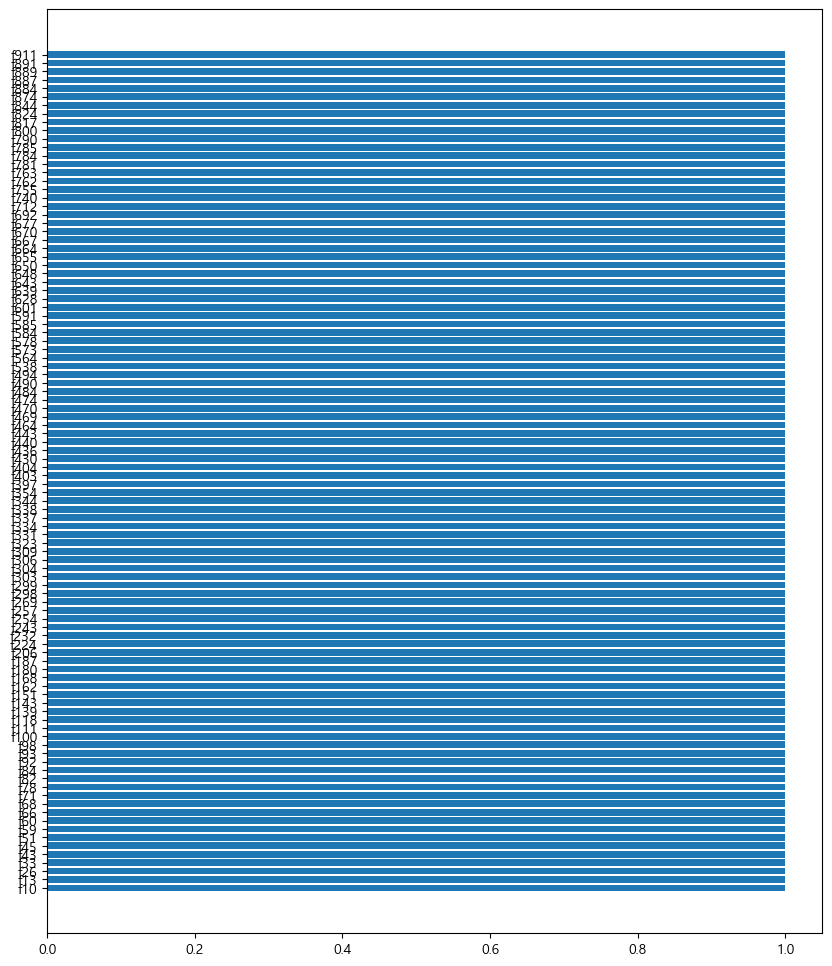

In [15]:
importance = models[-1].get_booster().get_score(importance_type="weight")
tuples = [(k, importance[k]) for k in importance]
tuples.sort(key=lambda x: x[1])

label, values = zip(*tuples)

plt.rcParams["font.family"] = "MalGun Gothic"
plt.figure(figsize=(10, 12))
plt.barh(label[:100], values[:100])
plt.show()

In [16]:
submit = pd.read_csv("./xgboost_optuna.csv")
submit["HLM"] = y_tests[-1]
submit.to_csv("xgboost_optuna.csv", index=False)